# Autoencoder (AE) and denoising AE

## Introduction

In the past lab we have used the low-level API of PyTorch to implement an MLP. We trained the model to fit a synthetic data set and we experimented with different batch sizes and learning rates.

In this lab we will use one of PyTorch high-level APIs: `torch.nn`. This time we will experiment on more complex and natural datasets: MNIST or Fashion-MNIST.


## Objectives
- Learn to use the PyTorch `nn` API
- Build, train and use a simple MLP
- Build, train and use a more advanced CNN

## Outline
- Download MNIST
- Create and train a dense autoencoder (AE) that encodes-decodes images
- Plot images and reconstructions
- Refine the model with an output activation
- Visualize the first two dimensions of the codes
- Visualize all dimensions of the codes using PCA or TSNE
- Generate random images
- Interpolate between two images
- Classify images by code
- CNN Autoencoder
- Denoising AE with Gaussian noise

Optionals:
- Replace the encoder with a MobileNet v2 backbone
- Create a denoising AE with masks
- Create a denoising AE with an exotic distortion of choice
- Create a superresolution AE


## Getting started

We will first import all necessary modules:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

## Exercise 1 : MNIST preparation

Prepare the datasets for the MNIST corpus.

In [2]:
### BEGIN SOLUTION

#Defining the transform characterstics
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5), (0.5))
])

#Bringing in the MNIST train dataset (1-channel, 28x28 pixel, 60,000 training images)
train_set=torchvision.datasets.MNIST('/content',train=True, transform = transform,download=True)

#Bringing in the MNIST test dataset (1-channel, 28x28 pixel, 10,000 test images)
test_set=torchvision.datasets.MNIST('/content',train=False, transform = transform,download=True)

### END SOLUTION

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



## Exercise 2 : Feed-forward Autoencoder
An autoenoder (AE) is composed of two subnetworks, an **encoder** that transforms the input image into a multidimensional vector known as the **code** (with size decided by the user), and a **decoder** subnetwork that reconstructs the input image from the code.

Implement an AE with a 2 dense layer encoder and 2 dense layer decoder, with 128 hidden units each. The code should have 32 dimensions.

In [48]:
class DenseAutoEncoder(nn.Module):
    def __init__(self, input_shape, code_dim=32, hidden_dim=128):
        super().__init__()
        
        input_dim = torch.prod(torch.tensor(input_shape))
        
        self.encoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Flatten(1), #Flatening the 28x28 images to an arrays of 784 to be used with Linear layer
            nn.Linear(input_dim, hidden_dim), #Linear will take 784 images and maps them to 128 outputs
            nn.ReLU(), #Activation Function (0 for input < 0 and otherwise input = output)
            nn.Linear(hidden_dim, code_dim), #Using Linear layer again to map 128 input to output dimension of 32
            ### END SOLUTION
            )
        
        self.decoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Linear(code_dim, hidden_dim), #Using Linear layer to map 32 code input to output dimension of 128 
            nn.ReLU(), #Activation Function (0 for input < 0 and otherwise input = output)
            nn.Linear(hidden_dim, input_dim), #Linear will take 128 input size and maps them to 784
            nn. Unflatten(1, input_shape) #Unflatten to 1x28x28
            ### END SOLUTION
            )
    

    def forward(self, ims):
        ### BEGIN SOLUTION

        # Compute the codes using the encoder
        codes = self.encoder(ims) #Generating latent code from images
        decoded = self.decoder(codes) #Recreating images from latent code
        return decoded, codes

        
input_shape = train_set[0][0].shape #Computing the shape of the images (1x28x28)
print(DenseAutoEncoder(input_shape, code_dim=32, hidden_dim=128)) #Printing the created network specifications 

DenseAutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
  )
)


## Exercise 3 : Training the AE
Write a function that trains the autoencoder.

In [49]:
def train(model, dataloader, nepochs=1, lr=1e-3):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #Use GPU if available
    model.train() #Train Model mode

    ### BEGIN SOLUTION
    
    # Using an Adam Optimizer with lr = 1e-3 and weight decay = 1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

    # Create the MSE criterion
    criterion = nn.MSELoss() #Mean Squared Error based Loss Function

    ### END SOLUTION

    # Move model and criterion to the device
    model = model.to(device) #Migrate model to CUDA
    criterion = criterion.to(device) #Migrate criterion to CUDA

    # Variables to track the running average of the loss
    running_loss = 0.
    running_samples = 0

    for epoch in range(nepochs):
        for it, data in enumerate(dataloader):
            ### BEGIN SOLUTION
            # Unpack the data into ims and labels          
            ims, label = data
            # Move ims into the device
            ims = ims.to(device) ##Migrate images to CUDA

            # Zero the gradients
            optimizer.zero_grad() 

            # Forward pass of the model
            est_img, code = model(ims)

            # Compute the loss
            loss = criterion(est_img, ims)

            ### END SOLUTION

            running_loss += loss
            running_samples += ims.shape[0]

            if it % 100 == 0:
                print(f'ep: {epoch}, it: {it}, loss : {running_loss/running_samples:.5f}')
                running_loss = 0.
                running_samples = 0

            ### BEGIN SOLUTION
            # Compute the gradients
            loss.backward()

            # Perform optimization step
            optimizer.step()

            ### END SOLUTION

input_shape = train_set[0][0].shape
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)

model_1 = DenseAutoEncoder(input_shape, code_dim=32, hidden_dim=128)
train(model_1, train_loader, nepochs=3, lr=1e-3)

ep: 0, it: 0, loss : 0.01450
ep: 0, it: 100, loss : 0.00436
ep: 0, it: 200, loss : 0.00221
ep: 0, it: 300, loss : 0.00183
ep: 0, it: 400, loss : 0.00157
ep: 0, it: 500, loss : 0.00142
ep: 0, it: 600, loss : 0.00132
ep: 0, it: 700, loss : 0.00125
ep: 0, it: 800, loss : 0.00122
ep: 0, it: 900, loss : 0.00117
ep: 1, it: 0, loss : 0.00119
ep: 1, it: 100, loss : 0.00112
ep: 1, it: 200, loss : 0.00111
ep: 1, it: 300, loss : 0.00113
ep: 1, it: 400, loss : 0.00110
ep: 1, it: 500, loss : 0.00110
ep: 1, it: 600, loss : 0.00109
ep: 1, it: 700, loss : 0.00108
ep: 1, it: 800, loss : 0.00109
ep: 1, it: 900, loss : 0.00106
ep: 2, it: 0, loss : 0.00109
ep: 2, it: 100, loss : 0.00104
ep: 2, it: 200, loss : 0.00104
ep: 2, it: 300, loss : 0.00107
ep: 2, it: 400, loss : 0.00105
ep: 2, it: 500, loss : 0.00105
ep: 2, it: 600, loss : 0.00104
ep: 2, it: 700, loss : 0.00104
ep: 2, it: 800, loss : 0.00105
ep: 2, it: 900, loss : 0.00102


## Exercise 4 : Plot reconstructions

Create a function `plot_image_row` to visualize a set of images as a row using `plt.subplots`.

We then provide a function `plot_images` that plots the image sets past as arguments in consecutive rows by using `plot_image_row`.

Create a function `forward_one_batch` which given a dataset creates a batch and runs the model to produce images.

Finally create a function `ex_compare_reconstructions` which takes two datasets (usually train and test), runs the model on a batch and plots the reconstructions under the ground-truths

Train set


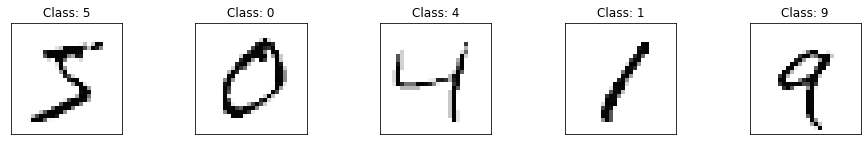

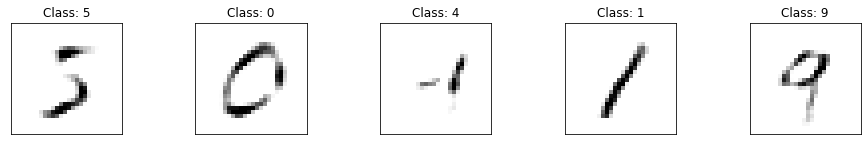

Test set


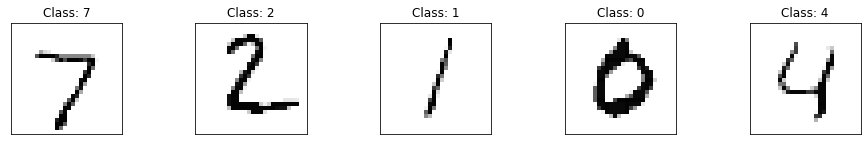

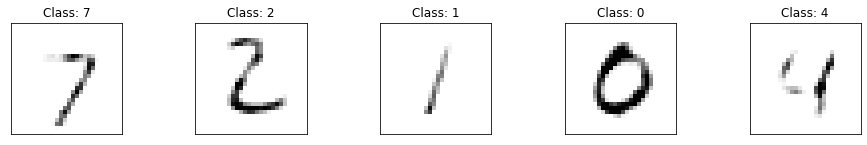

In [50]:
def plot_image_row(ims, labels = None):

      ims = ims.detach().cpu().numpy()

      #plt.imshow accepts images in the form (xx,yy, channels) where here it would be (channel,xx,yy)
      #For 1-channel images we can squeeze out the additional dimension, but we are given 3-channels
      #we gonna swapaxes to make it compatible for displaying 3-channel images (additional provision)
      
      if np.size(ims,1) == 1: #For Grayscale or 1-channel Images
        ims = ims.squeeze(1) #Squeezing the unnecessary channel dimension
      elif np.size(ims,1) == 3: #Axes correction for plt.imshow for 3-channel images
        ims = ims.swapaxes(1,2) #Axes sweeping
        ims = ims.swapaxes(2,3)
        #Above is done because if the color intensity is a float, then matplotlib expects it to range from 0 to 1. If an int, 
        #then it expects 0 to 255. So you can either force all the numbers to int or scale them all by 1/255.
      else: 
        print("Dimension of provided Images are Invalid")

      ### BEGIN SOLUTION
      plt.figure(figsize=(16,4.5))
      n = 5
      for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(ims[i], cmap='Greys',vmin=0,vmax=1)
        if labels is not None:
          ax.set_title('Class: {}'.format(labels[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

      plt.show()


def plot_images(*args):

    for arg in args:
        
        if len(args) > 1 and arg.ndim >1: #Plot Images with labels if labels are given as additional argument
          plot_image_row(arg,args[2])
        elif arg.ndim >1: #Otherwise print only the images
          plot_image_row(arg)
          
        else:
          pass

    
def forward_one_batch(model, dataset, batch_size):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device) #Migrate images to CUDA for faster computation

    model.eval() #Set Evaluation Mode

    ### BEGIN SOLUTION 
    ims, labels = next(iter(torch.utils.data.DataLoader(dataset, batch_size))) #Get one batch of data
    ims = ims.to(device) #Migrate images to CUDA for faster computation
    with torch.no_grad(): #As we are not training, temporarily set the reguireds_grad of tensor False
      ims_est, codes = model(ims) #Forward pass the batch data over the model

    ### END SOLUTION

    return ims, codes, ims_est, labels

def ex_compare_reconstructions(model, train_set, test_set):
    print('Train set')
    ### BEGIN SOLUTION
    ims, codes, ims_est, labels = forward_one_batch(model, train_set, batch_size = 32) 
    plot_images(ims, ims_est, labels) #Plot images with labels
    ### END SOLUTION

    print('Test set')
    ### BEGIN SOLUTION
    ims, codes, ims_est, labels = forward_one_batch(model, test_set, batch_size = 32)
    plot_images(ims, ims_est, labels) ##Plot images with labels
    ### END SOLUTION

ex_compare_reconstructions(model_1, train_set, test_set)

## Exercise 5 : Range of pixels

If we look carefully we observe the range of values for the pixels of the estimated images is different from that of the input images to the model.

For a batch of 64 images of the train set, **print the min and max values** of the images inputed to the model versus those estimated by it.

In [52]:
### BEGIN SOLUTION
model = DenseAutoEncoder(input_shape, code_dim=32, hidden_dim=128)
ims, codes, ims_est, labels = forward_one_batch(model, train_set, batch_size = 64)


max_original = torch.max(ims) #Find Maximum of orignal image intensity in one batch
min_original = torch.min(ims) #Find Minimum of original image intensity in one batch

max_est = torch.max(ims_est) #Find Maximum of estimated image intensity in one batch
min_est = torch.min(ims_est) #Find Minimum of estimated image intensity in one batch

print(max_original, min_original) #Printing, as original images are normalized, it will be fixed 1 and -1 respectively
print(max_est, min_est) #Priniting

### END SOLUTION

tensor(1.) tensor(-1.)
tensor(0.3145) tensor(-0.4073)


## Exercise 6 : Output activation function

Select an activation function for the output layer that better suits our data.
- Modify the model to add this activation function
- Train the new model for 3 epoch
- Plot the images

In [53]:
class DenseAutoEncoderOutAct(nn.Module): 
    def __init__(self, input_shape, code_dim=32, hidden_dim=128):
        super().__init__()

        input_dim = torch.prod(torch.tensor(input_shape))
        
        self.encoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Flatten(1), #Flatening the 28x28 images to an arrays of 784 to be used with Linear layer
            nn.Linear(input_dim, hidden_dim), #Linear will take 784 images and maps them to 128 outputs
            nn.Tanh(), #Activation Tanh (between -1 and 1) better suited for our case as image intensities are between -1 and 1
            nn.Linear(hidden_dim, code_dim), #Linear will take input size of 128 and maps them to code size of 32
            nn.Tanh() #Activation Function
            ### END SOLUTION
            )
        
        self.decoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Linear(code_dim, hidden_dim), #Using Linear layer to map 32 code input to output dimension of 128 
            nn.Tanh(), #Activation Function
            nn.Linear(hidden_dim, input_dim),#Linear will take 128 input size and maps them to 784
            ## activiation
            nn.Tanh(), #Activation Function
            nn.Unflatten(1, input_shape), #Unflatten to get reconstructed image shape
            ### END SOLUTION
            )

    def forward(self, ims):
        ### BEGIN SOLUTION
        # Compute the codes using the encoder
        codes = self.encoder(ims)
        decoded = self.decoder(codes)
        return decoded, codes
        
input_shape = train_set[0][0].shape
model_2 = DenseAutoEncoderOutAct(input_shape, code_dim=32, hidden_dim=128)
train(model_2, train_loader, nepochs=3)

"""Before properly using activation functions in model_2, the loss was "0.00241". In earlier feed-forward model (model_1) with few ReLUs, 
the loss is "0.00103". Now when we have properly used Tanh (rightly selection of activation function as well as at right layer) in this model the loss 
has dropped to 0.00088 that signifies the role of activation choice"""

ep: 0, it: 0, loss : 0.01478
ep: 0, it: 100, loss : 0.00503
ep: 0, it: 200, loss : 0.00361
ep: 0, it: 300, loss : 0.00310
ep: 0, it: 400, loss : 0.00266
ep: 0, it: 500, loss : 0.00236
ep: 0, it: 600, loss : 0.00222
ep: 0, it: 700, loss : 0.00203
ep: 0, it: 800, loss : 0.00192
ep: 0, it: 900, loss : 0.00174
ep: 1, it: 0, loss : 0.00171
ep: 1, it: 100, loss : 0.00159
ep: 1, it: 200, loss : 0.00149
ep: 1, it: 300, loss : 0.00149
ep: 1, it: 400, loss : 0.00141
ep: 1, it: 500, loss : 0.00136
ep: 1, it: 600, loss : 0.00133
ep: 1, it: 700, loss : 0.00128
ep: 1, it: 800, loss : 0.00128
ep: 1, it: 900, loss : 0.00119
ep: 2, it: 0, loss : 0.00120
ep: 2, it: 100, loss : 0.00113
ep: 2, it: 200, loss : 0.00110
ep: 2, it: 300, loss : 0.00111
ep: 2, it: 400, loss : 0.00105
ep: 2, it: 500, loss : 0.00103
ep: 2, it: 600, loss : 0.00101
ep: 2, it: 700, loss : 0.00098
ep: 2, it: 800, loss : 0.00099
ep: 2, it: 900, loss : 0.00093


'Before properly using activation functions in model_2, the loss was "0.00241". In earlier feed-forward model (model_1) with few ReLUs, \nthe loss is "0.00103". Now when we have properly used Tanh (rightly selection of activation function as well as at right layer) in this model the loss \nhas dropped to 0.00088 that signifies the role of activation choice'

Train set


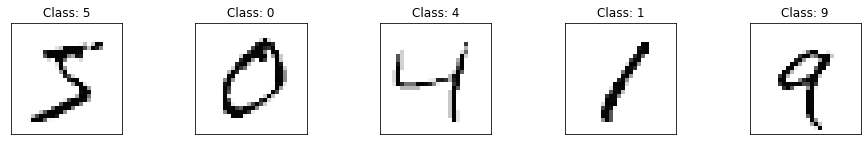

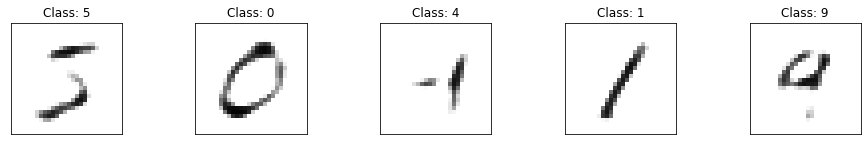

Test set


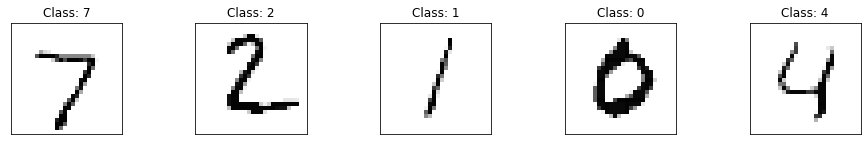

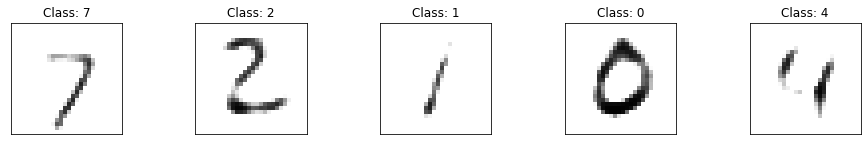

'Better reconstruction of images by model_2 (model with better activations) than with the earlier model_1'

In [54]:
### BEGIN SOLUTION
# Plot reconstruction using the new model
ex_compare_reconstructions(model_2, train_set, test_set)
### END SOLUTION
"""Better reconstruction of images by model_2 (model with better activations) than with the earlier model_1"""

## Exercise 7 : Plot the codes

As we can see we have succesfully encoded a 28x28 (=784) image into a 32-dimensional vector code.  This code compresses the information of the image by over 20 times and yet contains the information necessary to approximately reconstruct the image. The latent space of the code must have a certain structure to allow this.

Let's explore it by creating a **scatter plot** of the first two dimensions of the codes, and assigning a **different color to each digit**. Plot the **codes of 5% of the points in the training set**.

**Hint** consider using multiple calls to `plt.scatter` where each call plots the codes of a particular digit. Don't set the color of the points (keyword argument `c`) so that it automatically cycles over different colors. Set the `label` keyword argument of each scatter to the digit being plotted, this way the legend will have the correct information.

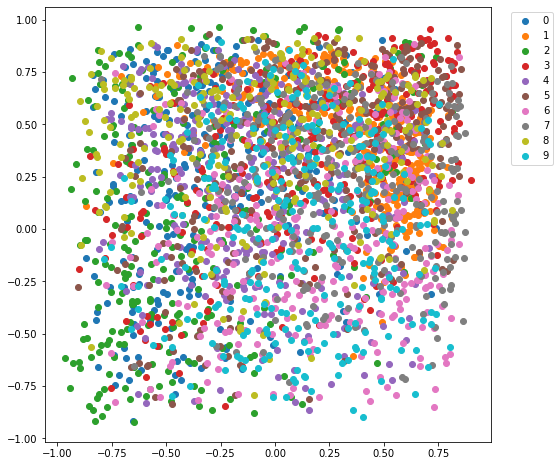

'The code distribution is really spreaded and the separation is not apparently identifiable. But AE could be seen as \na technique to reduce dimension (get more dimensional inputs to lower dimension latent space i.e. it could be seen as \nnon-linear extension of Dimension Reduction Technique e.g. PCA). More discussion on latent space is done in Excerse 11 \nas well as in the next task'

In [55]:
def ex_plot_codes(model, train_set):
    ### BEGIN SOLUTION
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # Forward the model on one batch
    batch_size = int(len(train_set) * 5/100) #batch size equivalent to 5% of training set
    ims, labels = next(iter(torch.utils.data.DataLoader(train_set, batch_size))) #Taking one batch
    ims = ims.to(device) #Migrate images to CUDA
    model.eval() #Setting model in evaluation mode
    with torch.no_grad(): #As we are not training, temporarily set the require_grads of tensor False
      ims_est, codes = model(ims) #forward pass images over the model

    ### END SOLUTION

    # Move codes and labels back to the CPU and convert to numpy
    codes = codes.cpu().detach().numpy() 
    labels = labels.cpu().detach().numpy()

    plt.figure(figsize=(8, 8))

    # For each digit
    for i in range(10):
        ### BEGIN SOLUTION
        plt.scatter(codes[labels == i][:,0],codes[labels == i][:,1], label = i)
        #Scatter plot of first two dimensions of code, indexes where specified labels(i) ==i is 'True'
        ### END SOLUTION
    plt.legend(bbox_to_anchor=(1.15, 1))
    plt.show()

ex_plot_codes(model_2, train_set)

"""The code distribution is really spreaded and the separation is not apparently identifiable. But AE could be seen as 
a technique to reduce dimension (get more dimensional inputs to lower dimension latent space i.e. it could be seen as 
non-linear extension of Dimension Reduction Technique e.g. PCA). More discussion on latent space is done in Excerse 11 
as well as in the next task"""

## Exercise 8 : Plot the PCA of codes

In the previous visualisation we could start appreciating certain structure with points of same colour clustered together. This means that codes for the same digit are positioned close to each other.

However we were only plotting 2 dimensions of the 32 in the code. We may use a better projection to plot on a 2-dimensional plane by using a dimensionality reduction technique.

Re-do the plot from the previous exercise, this time by applying PCA in order to reduce to 2 dimensions.

We will use [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

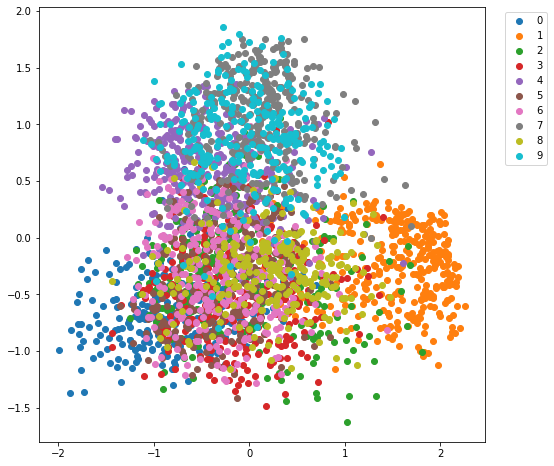

'We see slightly better results than using codes (earlier task) in terms of separation/structure of different \ncoloured clusters (because we are using all code dimension not just first two), but digits are still intermixed. \nMore discussion on latent space is done in Excerse 11 as well as in the next task'

In [56]:
from sklearn.decomposition import PCA

def ex_plot_codes_pca(model, train_set):
    ### BEGIN SOLUTION
    # Forward the model on one batch
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    batch_size = int(len(train_set) * 5/100) #batch size equivalent to 5% of training set
    ims, labels = next(iter(torch.utils.data.DataLoader(train_set, batch_size))) 
    ims = ims.to(device) #Migrate images to CUDA
    
    model.eval() #Setting model in evaluation mode
    with torch.no_grad(): #As we are not training, temporarily set the require_grads of tensor False
      ims_est, codes = model(ims) #forward pass images over the model
    ### END SOLUTION

    # Move codes and labels back to the CPU and convert to numpy
    codes = codes.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

    ### BEGIN SOLUTION
    """Linear dimensionality reduction using Singular Value 
    Decomposition of the data to project it to a lower dimensional space. """
    pca = PCA(n_components=2) #Number of components to keep is 2
    principalComponents=pca.fit_transform(codes) #
    ### END SOLUTION

    plt.figure(figsize=(8, 8))

    # For each digit
    for i in range(10):
        ### BEGIN SOLUTION
        plt.scatter(principalComponents[labels == i][:,0],principalComponents[labels == i][:,1], label = i)

        ### END SOLUTION
    plt.legend(bbox_to_anchor=(1.15, 1))
    plt.show()

ex_plot_codes_pca(model_2, train_set)
"""We see slightly better results than using codes (earlier task) in terms of separation/structure of different 
coloured clusters (because we are using all code dimension not just first two), but digits are still intermixed. 
More discussion on latent space is done in Excerse 11 as well as in the next task"""

## Exercise 9 : Plot the TSNE of codes

With the PCA dimensionality reduction we are able to reveal more structure, but the linear projection of  PCA is not sufficient to represent the structure in such data. Instead we may use a non-linear method.

TSNE is an approach that can produce a low-dimensional embedding of the data that maintains local distribution of distances between points. Points that are close in the high-dimensional code space should be close in the low-dimensional space we embed in (2-D in our case for plotting.

Re-do the plot this time using a 2-D TSNE embedding.

We will use [`sklearn.manifold.TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

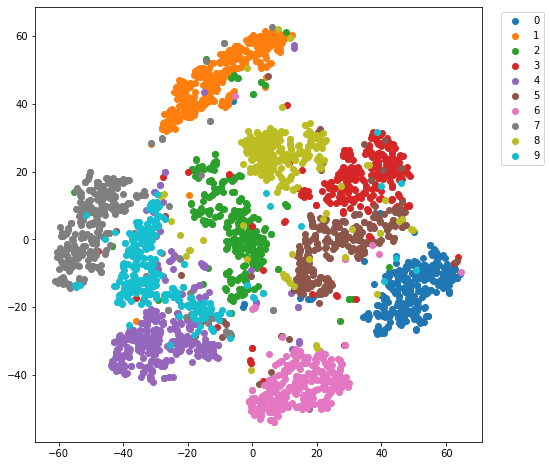

'We also notice that the digits that are similar in shape are close to each other. For example,\nzero(0) is really different shape wise from one(1). Similarly, 4 and 9 are very similar so they are almost \noverlapping in the map. More discussion on latent space is done in Excerse 11 as well as in the next task'

In [57]:
from sklearn.manifold import TSNE

def ex_plot_codes_tsne(model, train_set):
        ### BEGIN SOLUTION
    # Forward the model on one batch
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    batch_size = int(len(train_set) * 5/100) #batch size equivalent to 5% of training set
    ims, labels = next(iter(torch.utils.data.DataLoader(train_set, batch_size)))
    ims = ims.to(device) #Migrate images to CUDA
    model.eval() #Setting model in evaluation mode
    with torch.no_grad(): #As we are not training, temporarily set the require_grads of tensor False
      ims_est, codes = model(ims) #forward pass images over the model

    ### END SOLUTION

    # Move codes and labels back to the CPU and convert to numpy
    codes = codes.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

    ### BEGIN SOLUTION
    tsne_embeddings = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(codes)

    ### END SOLUTION

    plt.figure(figsize=(8, 8))

    # For each digit
    for i in range(10):
        ### BEGIN SOLUTION
        plt.scatter(tsne_embeddings[labels == i][:,0],tsne_embeddings[labels == i][:,1], label = i)

        ### END SOLUTION
    plt.legend(bbox_to_anchor=(1.15, 1))
    plt.show()

ex_plot_codes_tsne(model_2, train_set)

"""We are seeing significant improvement in results compared to using codes and PCA (earlier tasks) in terms of separation/structure of different 
coloured clusters, and majorly digit's group are now farther away from each other.

tSNE performs better over PCA due to following reasons:
1) tSNE do non-linear scaling of dimensions to optimally represent changes in every dimension
2) tSNE is better in optimal separation over 2-dimensions
However, tSNE usgae involve following considerations:
1) More hyperparaters
2) Not good in dealing noisy data
3) tSNE is slow

Therefore, the better of both above is UMAP method (Uniform Manifold Approximation and Projection).
This method is very similar to tSNE, but with few modifications

We also notice that the digits that are similar in shape are close to each other. For example,
zero(0) is really different shape wise from one(1). Similarly, 4 and 9 are very similar so they are almost 
overlapping in the map. More discussion on latent space is done in Excerse 11 as well as in the next task"""

## Exercise 10 : Classify using codes

As we see from the TSNE embedding the latent space of codes retains a structure related to the classes of the images. Note that no labels have been used in the training of the autoencoder nor the TSNE.

Lets see if this latent space is better suited for classifying the images than the pixel space directly.

Print the accuracy on the test set of two 5-nearest neighbour classifiers trained on 1% of the training set:

1. Classifier trained on pixel space
2. Classifier trained on latent space (codes)

We will use [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

def ex_compare_classifiers(model, train_set, test_set):
    # Forward a model on the train set
    batch_size = int(len(train_set) * 1/100) ##batch size equivalent to 1% of training set
    
    # Collect the images, codes and labels train
    train_x_pixel, train_x_latent, _, train_y = forward_one_batch(model, train_set, batch_size)

    # Flatten and convert to numpy the images, codes and labels
    train_x_pixel = train_x_pixel.flatten(1).detach().cpu().numpy()
    train_x_latent = train_x_latent.detach().cpu().numpy()
    train_y = train_y.detach().cpu().numpy()

    # Collect the images, codes and labels of test
    batch_size = len(test_set) #Computing the length of test data (test data will be used as whole as batch)
    test_x_pixel, test_x_latent, _, test_y = forward_one_batch(model, test_set, batch_size)

    # Flatten and convert to numpy the images, codes and labels
    test_x_pixel = test_x_pixel.flatten(1).detach().cpu().numpy()
    test_x_latent = test_x_latent.detach().cpu().numpy()
    test_y = test_y.detach().cpu().numpy()

    ### BEGIN SOLUTION
    
    #Classifying using pixels
    pixel_classifier = KNeighborsClassifier(n_neighbors=5) #5 number of neighbors, as per specifications
    pixel_classifier.fit(train_x_pixel, train_y) #Training/Fitting the algorithm with pixelated training data
    pixel_acc = pixel_classifier.score(test_x_pixel, test_y) #Evaluating the accuracy on test data

    #Classifying using latent codes
    code_classifier = KNeighborsClassifier(n_neighbors=5) #5 number of neighbors, as per specifications
    # Train the classifier on train data
    code_classifier.fit(train_x_latent, train_y)  #Training/Fitting the algorithm with latent code-based training data
    # Evaluate the classifier on test data
    latent_acc = code_classifier.score(test_x_latent, test_y) #Evaluating the accuracy on latent code-based test data
    ### END SOLUTION

    print(f'Pixel space accuracy: {pixel_acc:.2%}')
    print(f'Latent space accuracy: {latent_acc:.2%}')

#calling function to compare both classifiers
ex_compare_classifiers(model_2, train_set, test_set)

"""The latent space classification accuracy is better than pixel space"""

Pixel space accuracy: 81.20%
Latent space accuracy: 84.60%


'The latent space classification accuracy is better than pixel space'

## Exercise 11 : Generate random images

Now we will see how to use our model to produce new images.

To do so we will pick a code at random and run a forward pass on the decoder. In order to pick plausible codes, we will sample them from a Gaussian fitted on the training set codes.

Generate and plot 8 random images:
- Find the mean and stddev of the codes of a 10% of the training data
- Create and sample 8 codes from a Normal with the mean and stddev found
- Run a forward pass of the decoder of our trained AE model on the generated codes
- Reshape the outputs of the decoder into MNIST-like images
- Plot the generated images

**Hint** you may use [`torch.distributions.normal.Normal`](https://pytorch.org/docs/stable/distributions.html#torch.distributions.normal.Normal) to build and sample from a Normal distribution.

<Figure size 1152x324 with 0 Axes>

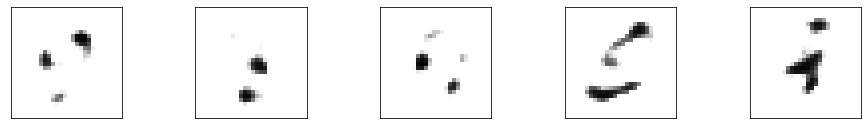

'For generation, the fundamental problem with autoencoders is that the latent space (where encoded vectors lie) is not completely continuous\n or allow easy interpolation. In other words, the encoding onto latent plot can not very well deal with inputs that the encoder has never seen \n before because different classes are clustered but in between them is void and unseen inputs could be encoded to an area somewhere in that void.\n Therefore, for generating purposes Variational Autoencoder(VAE), due to additional regularizer, are better. So conclusion of discusion is to denoise/to classify(filter dissimilar data), \n a standard autoencoder would be enough, but we should better use variational autoencoder for image generation.'

In [58]:
from torch.distributions.normal import Normal

def decode_images(model, codes):
    ### BEGIN SOLUTION

    model.eval()
    # Forward of the decoder on the codes and reshape
    with torch.no_grad():
      ims = model.decoder(codes)
    #Not reshaping as we already did
    ### END SOLUTION
    return ims

def ex_generate_images(model, train_set):
    ### BEGIN SOLUTION
    # Create a Normal distribution for the codes of 10% of training data
    batch_size = int(len(train_set) * 10/100) #batch size lenght is 10% of training set
    ims, codes, _, labels = forward_one_batch(model, train_set, batch_size) #pass to function
    std, mean = torch.std_mean(codes, dim = 0) #calculate mean and standard deviation along axis 0

    # Sample codes
    code_distribution = Normal(mean, std) #Create normal distribution with given mean and std
    code_sampled = code_distribution.sample((8,)).reshape(-1,32) #Randomly sample 8 and then reshape
    # Forward of the decoder on the codes and reshape
    gen_ims = decode_images(model, code_sampled) #Given codes, generate images
    
    ### END SOLUTION

    # Plot the images
    plt.figure(figsize=(16,4.5))

    plot_images(gen_ims)

ex_generate_images(model_2, train_set)

"""For generation, the fundamental problem with autoencoders is that the latent space (where encoded vectors lie) is not completely continuous
 or allow easy interpolation. In other words, the encoding onto latent plot can not very well deal with inputs that the encoder has never seen 
 before because different classes are clustered but in between them is void and unseen inputs could be encoded to an area somewhere in that void.
 Therefore, for generating purposes Variational Autoencoder(VAE), due to additional regularizer, are better. So conclusion of discusion is to denoise/to classify(filter dissimilar data), 
 a standard autoencoder would be enough, but we should better use variational autoencoder for image generation."""

## (Optional) Exercise 11b : Generate particular digits

Do the same but fit the Gaussian distribution used for generating codes only on training data corresponding to the digit 0.

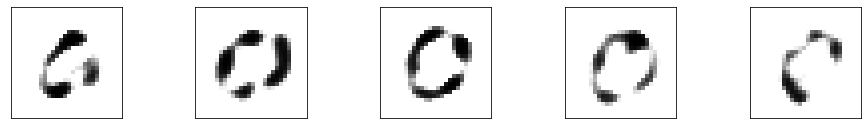

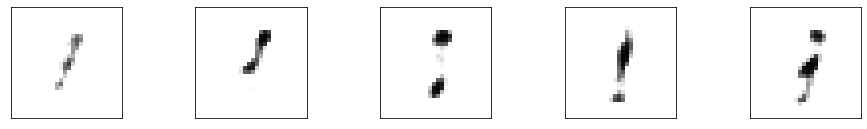

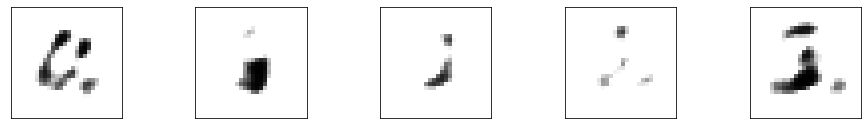

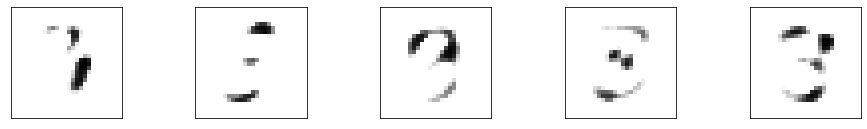

'From the visuals, we can see the model is able to reconstruct the digits to some extent (digits that are uniform\nor symmetric have better reconstruction i.e. 0 or 1)'

In [14]:
def ex_generate_digit_images(model, train_set, digit=0):
    ### BEGIN SOLUTION
    # Forward the model on 20% of the data (specification)

    batch_size = int(len(train_set) * 20/100) #batch size lenght is 20% of training set
    ims, codes, _, labels = forward_one_batch(model, train_set, batch_size) #pass to function

    # Only keep codes corresponding to the digit given by the keyword argument
    ##Here we will calculate std and mean of specific code indexes (specific digits) 
    std, mean = torch.std_mean(codes[[labels == digit]], dim = 0) 
    
    # Create a normal distribution with the mean and std
    code_distribution = Normal(mean, std) #Calculate mean and normal distribution
    
    # Sample codes
    code_sampled = code_distribution.sample((8,)).reshape(-1,32) #Randomly sample 8 and then reshape

    # Decode images
    gen_ims = decode_images(model, code_sampled) #Given codes, generate images
    
    ### END SOLUTION

    # Plot the images
    plot_images(gen_ims)

ex_generate_digit_images(model_2, train_set, digit=0)
ex_generate_digit_images(model_2, train_set, digit=1)
ex_generate_digit_images(model_2, train_set, digit=2)
ex_generate_digit_images(model_2, train_set, digit=3)

"""From the visuals, we can see the model is able to reconstruct the digits to some extent (digits that are uniform
or symmetric have better reconstruction i.e. 0 or 1)"""

## Exercise 12 : Interpolate between images

Given that we can use any random code to generate images, one may ask what happens if we interpolate between the codes of two given images and decode into images the interpolated codes.

Create a function `encode_images` that computes the codes of a batch of images.

Create a function `interpolate_tensors` that takes as input a start tensor and end tensor and a number of steps and computes the linear interpolation between them at regular steps. Preferably use [`torch.lerp`](https://pytorch.org/docs/stable/generated/torch.lerp.html) to compute the interpolated vectors.

Finally implement the function `ex_compare_interpolation` that takes a model and a dataset. The function must interpolate in pixel space and code space the first and second images of the dataset. It must perform the interpolation in 8 steps and plot the resulting interpolation.

Interpolated Images from pixel space


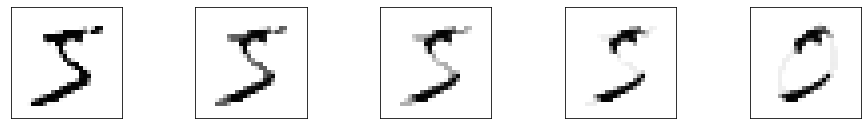

Interpolated images from codes


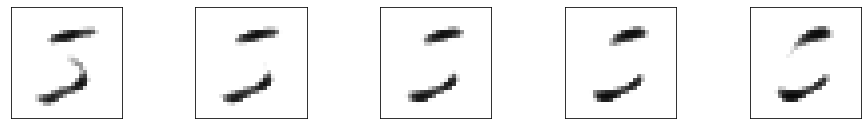

'We see that the interpolation from pixel space allows better reconstruction than the code space. This is linked to explanation\nprovided in Excercise 11, the AE code space is not very well organized and distributed.'

In [59]:
def encode_images(model, data):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    ### BEGIN SOLUTION
    batch_size = int(len(data) * 20/100) #batch size lenght is 20% of training set
    ims, codes, _, labels = forward_one_batch(model, data, batch_size) #pass to model
    ### END SOLUTION
    return ims, codes

def interpolate_tensors(start, end, steps):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    ### BEGIN SOLUTION
    # Create the weights
    # Weights are the normalized positions (from 0 to 1) where to interpolate
    #  between start and end
    
    ## weights are uniformly spaced so used linspace and unsqueezed to be broadcastable
    weights = ((torch.linspace(0,1,steps)).unsqueeze(1)).to(device) #Then migrate to CUDA

    # Compute the interpolation using torch.lerp
    interp_codes = torch.lerp(start, end, weights) #Linear interpolation between two flatten images
    ### END SOLUTION
    
    return interp_codes    

def ex_compare_interpolation(model, train_set):
    steps = 8
    ims, encode = encode_images(model, train_set) #Geting images and their code
    ### BEGIN SOLUTION
    im_first = ims[0] #Taking first image
    im_last = ims[1] #Taking secodn image
    # Interpolate the images in pixel space
    
    # Interpolate the flattened images
    interp_flatten = interpolate_tensors(torch.flatten(im_first), torch.flatten(im_last), steps)

    # Reshape the flattened images into images
    _, c, x, y = ims.size() #Get the size of orginal images for unflattening
    interp_flatten_reshaped = torch.reshape(interp_flatten, ([-1,c,x,y]))

    # Plot the images
    print('Interpolated Images from pixel space')
    plot_images(interp_flatten_reshaped) #Plot the image from code
    plt.show()

    # Interpolate the images in latent space
    encode_first= encode[0,:] #Taking in First image code
    encode_last = encode[1,:] #Taking in Second image code
    interp_encode = interpolate_tensors(encode_first, encode_last, steps)
    # Decode the images from the interpolated codes
    #interp_encode = torch.reshape(interp_encode, ([1,32]))

    interp_enc_ims = decode_images(model, interp_encode) #Decode code to images

    # Plot the images
    print('Interpolated images from codes')
    plot_images(interp_enc_ims) #Plot the image from code
    plt.show()
    ### END SOLUTION

ex_compare_interpolation(model_2, train_set)

"""We see that the interpolation from pixel space allows better reconstruction than the code space. This is linked to explanation
provided in Excercise 11, the AE code space is not very well organized and distributed."""

## Exercise 13 : CNN Autoencoder

Let's now focus on reimplementing our Autoencoder to use convolutional layers.

Implement a `CNNAutoEncoder` with the following architecture for the `encoder`:

```
Conv2d(1, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
...
Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
...
Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
...
Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
...
Linear(out_features=32)
```

and the following one for the `decoder`:
```
Linear(out_features=588)
...
ConvTranspose2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
...
Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
...
ConvTranspose2d(12, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
...
Conv2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
...
```

Note that I have omitted the activations. Use rectified linear units as non-linearity. Use the same output activation as for the previous AutoEncoder. You may also require other layers such as `nn.Flatten` and `nn.Unflatten`.

Note that we use `nn.ConvTranspose2d` (or fractional-strided convolutions) in the decoder. These assume that the inputs are interleaved with zeros, larger strides have more zero-value samples between the input pixels. This way we can obtain growth in spatial resolution when decoding the image. See an illustration of a fractional-strided convolution here:

![https://theano-pymc.readthedocs.io/en/latest/_images/padding_strides_transposed.gif](https://theano-pymc.readthedocs.io/en/latest/_images/padding_strides_transposed.gif)

Note as well that in this particular choice of architecture we depart from a convolution with `base_nchan` output filters. We alternate between convolutions of stride 2 and those with stride 1. The second convolution of stride 2 doubles the number of output channels. The input (and output) dimensions of the `Linear` layers in the encoder (and decoder) will depend on the `base_nchan`. For example, with the particular choice of `base_nchan=6` the `Linear` layer in the encoder will have an input dimension of `588`. However in the next cell we set the `base_nchan=4`, in this case input dimension of the `Linear` layer of the encoder will be different.

To find the correct computed value keep track of the sizes of the feature maps after each convolution and you will have to set the dimension of the `Linear` layers to something as follows:
```
XXX * YYY * (2*base_nchan)
```

for which you'll have to find the values of `XXX` and `YYY`. 

In [16]:
class CNNAutoEncoder(nn.Module):
    def __init__(self, input_shape, code_dim=32, base_nchan=6):
        super().__init__()

        input_nchan, x, _ = input_shape #Compute the shape of input (x,y) to last layer
        x1 = np.floor((x-3+2)/2+1) #This is helpful in inherenting this class and using it at other places
        x2 = np.floor((x1-3+2)/1+1)
        x3 = np.floor((x2-3+2)/2+1)
        xf = int(np.floor((x3-3+2)/1+1))
        self.encoder = nn.Sequential(
            #1x28x28
            nn.Conv2d(input_nchan, base_nchan, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            #6 x 14 x 14 ***Output_size = 1 + (Input Size - Filter size + 2 * Padding) / Stride
            nn.Tanh(),
            nn.Conv2d(base_nchan, base_nchan, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #6 x 15 x 15
            nn.Tanh(),
            nn.Conv2d(base_nchan, base_nchan*2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            #12 x 7 x 7
            nn.Tanh(),
            nn.Conv2d(base_nchan*2, base_nchan*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Tanh(),
            #12 x 7 x 7
            nn.Flatten(1),
            nn.Linear(xf*xf*base_nchan*2, out_features=code_dim)

            ### END SOLUTION
        )

        self.decoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Linear(code_dim, out_features=7*7*base_nchan*2),
            nn.Unflatten(1, (base_nchan*2, 7, 7)),
            nn.ConvTranspose2d(base_nchan*2, base_nchan*2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.Tanh(),
            nn.Conv2d(base_nchan*2, base_nchan*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Tanh(),
            nn.ConvTranspose2d(base_nchan*2, base_nchan, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.Tanh(),
            nn.Conv2d(base_nchan, input_nchan, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Tanh()
            ### END SOLUTION
        )

    def forward(self, ims):
        ### BEGIN SOLUTION
        codes = self.encoder(ims)
        decoded = self.decoder(codes)
        return decoded, codes

input_shape = train_set[0][0].shape
dummy = CNNAutoEncoder(input_shape, code_dim=32, base_nchan=6)


## Exercise 14 : CNN Autoencoder training and analysis

Train the newly created CNN AE.

And perform all the previous exercises on it. Simply run all the functions starting with `ex_...`.

Discuss the results.

In [17]:
input_shape = train_set[0][0].shape

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
model_3 = CNNAutoEncoder(input_shape, code_dim=32, base_nchan=4)
train(model_3, train_loader, nepochs=3)

"""I tried CNN with both ReLU and Tanh. The Tanh activation in case of CNNAutoencoder provides significantly better results.
Moreover, we can see here that CNN-based autoencoder is able to reduce loss much better than the simple feed-forward-based neural
network that highlights the CNN advantage over NN for images datset. Among many, one major reason for better result here, is CNN captures 
the pixel dependencies better than the feedforward neural network"""

ep: 0, it: 0, loss : 0.01648
ep: 0, it: 100, loss : 0.00770
ep: 0, it: 200, loss : 0.00446
ep: 0, it: 300, loss : 0.00383
ep: 0, it: 400, loss : 0.00229
ep: 0, it: 500, loss : 0.00158
ep: 0, it: 600, loss : 0.00127
ep: 0, it: 700, loss : 0.00110
ep: 0, it: 800, loss : 0.00099
ep: 0, it: 900, loss : 0.00090
ep: 1, it: 0, loss : 0.00091
ep: 1, it: 100, loss : 0.00081
ep: 1, it: 200, loss : 0.00074
ep: 1, it: 300, loss : 0.00073
ep: 1, it: 400, loss : 0.00068
ep: 1, it: 500, loss : 0.00068
ep: 1, it: 600, loss : 0.00065
ep: 1, it: 700, loss : 0.00064
ep: 1, it: 800, loss : 0.00063
ep: 1, it: 900, loss : 0.00060
ep: 2, it: 0, loss : 0.00063
ep: 2, it: 100, loss : 0.00057
ep: 2, it: 200, loss : 0.00056
ep: 2, it: 300, loss : 0.00057
ep: 2, it: 400, loss : 0.00054
ep: 2, it: 500, loss : 0.00055
ep: 2, it: 600, loss : 0.00053
ep: 2, it: 700, loss : 0.00053
ep: 2, it: 800, loss : 0.00054
ep: 2, it: 900, loss : 0.00051


'I tried CNN with both ReLU and Tanh. The Tanh activation in case of CNNAutoencoder provides significantly better results.\nMoreover, we can see here that CNN-based autoencoder is able to reduce loss much better than the simple feed-forward-based neural\nnetwork that highlights the CNN advantage over NN for images datset. Among many, one major reason for better result here, is CNN captures \nthe pixel dependencies better than the feedforward neural network'

Plot reconstructions
Train set


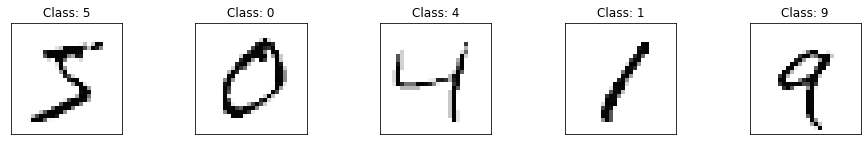

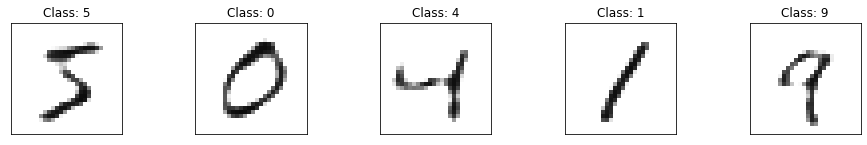

Test set


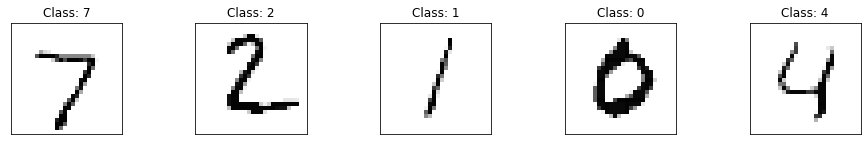

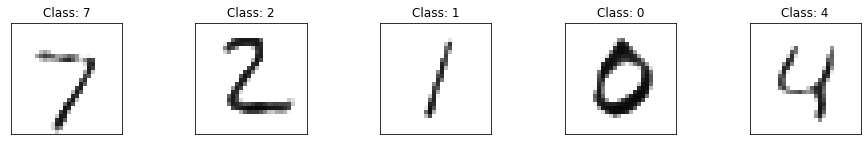

Plot the 1st and 2nd dimensions of codes


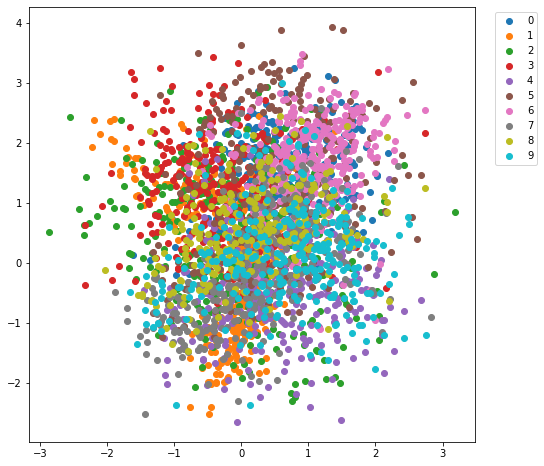

Plot the PCA of codes


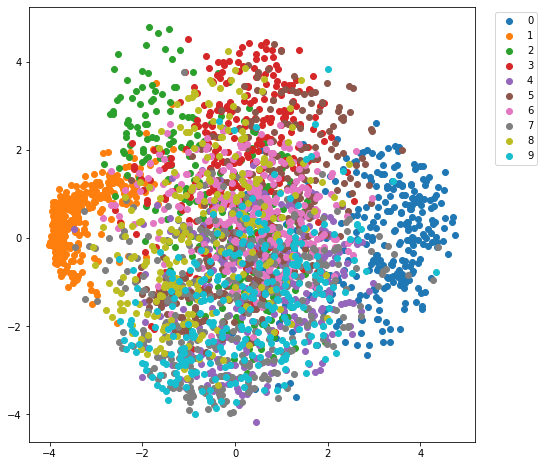

Plot the TSNE of codes


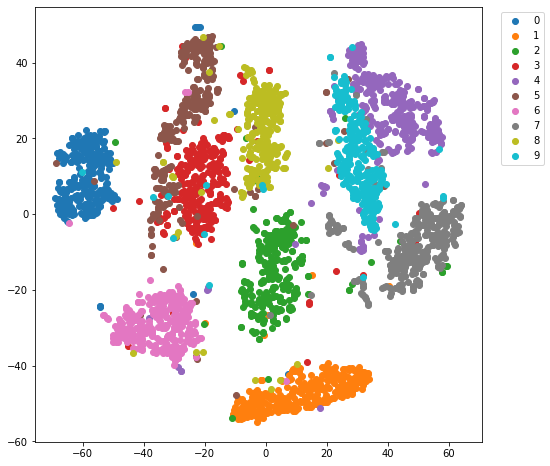

Classify using codes
Pixel space accuracy: 81.20%
Latent space accuracy: 86.97%
Generate random images


<Figure size 1152x324 with 0 Axes>

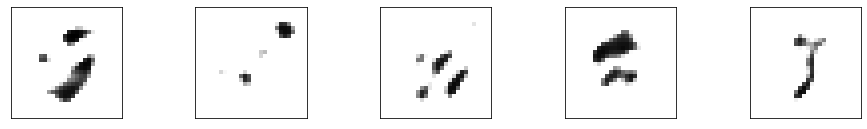

Generate particular digits


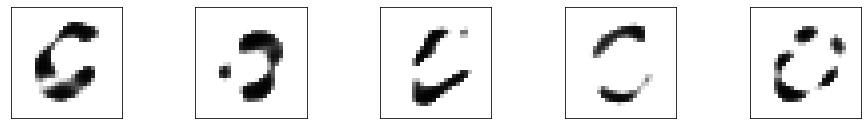

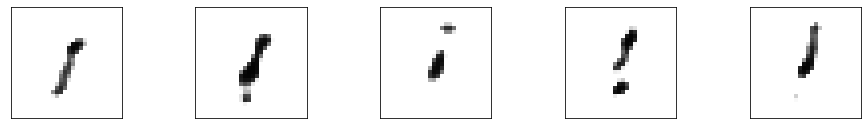

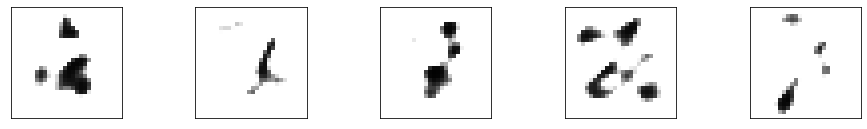

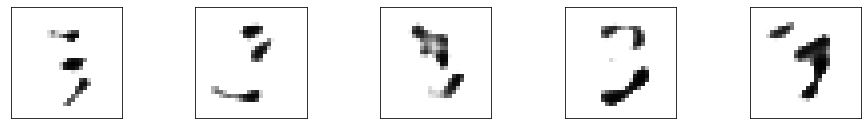

Interpolate between images
Interpolated Images from pixel space


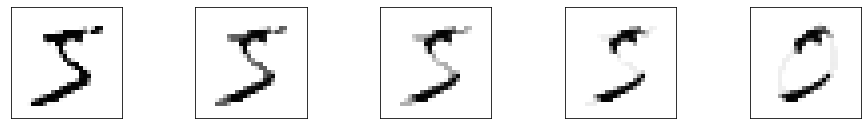

Interpolated images from codes


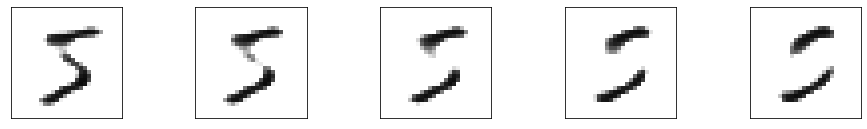

'Running all exercises on CNNAutoencoder, we clearly see improvement in results of every task.'

In [18]:
print('Plot reconstructions')
ex_compare_reconstructions(model_3, train_set, test_set)

print('Plot the 1st and 2nd dimensions of codes')
ex_plot_codes(model_3, train_set)

print('Plot the PCA of codes')
ex_plot_codes_pca(model_3, train_set)

print('Plot the TSNE of codes')
ex_plot_codes_tsne(model_3, train_set)

print('Classify using codes')
ex_compare_classifiers(model_3, train_set, test_set)

print('Generate random images')
ex_generate_images(model_3, train_set)

print('Generate particular digits')
ex_generate_digit_images(model_3, train_set, digit=0)
ex_generate_digit_images(model_3, train_set, digit=1)
ex_generate_digit_images(model_3, train_set, digit=2)
ex_generate_digit_images(model_3, train_set, digit=3)

print('Interpolate between images')
ex_compare_interpolation(model_3, train_set)

"""Running all exercises on CNNAutoencoder, we clearly see improvement in results of every task."""

## (Optional) Exercise 15 : Denoising Autoencoder

When we implemented our AE we decided that the task of the AE would take as input the original images and would have to reconstruct that same input.

This does not need to be so. Perhaps we may input a noisy version of the image and train the AE to reconstruct the clean version of the image.

Let's try to do this. We will first create a new dataset class `DenoisingDataset`, that takes as input an existing dataset and a transform function that should produce a distorted version of the input to be used as input to the AE.


**Note** that we can use `torchvision.transforms.Transform` classes as transforms here. As so, if we want to reproduce the setup of the original Autoencoder we can simply pass `transforms.Lambda(lambda x: x)` as a transform (which will leave the input unchanged).

Based on the previous `train` function, implement a new `train_denoising` function that accommodates the output of `DenoisingDataset`.

In [19]:
"""Below custom class is created. This really efficient way of doing modifications in orginal dataset"""

class DenoisingDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        super().__init__()

        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]

        input = data[0]
        transformed_input = self.transform(input)

        return (transformed_input, ) + data

train_set_2 = DenoisingDataset(train_set, transform=transforms.Lambda(lambda x: x))

In [60]:
def train_d(model, dataloader, nepochs=1, lr=1e-3):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.train()

    ### BEGIN SOLUTION
    # Create the Adam optimizer with weight_decay=1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

    # Create the MSE criterion
    criterion = nn.MSELoss()
    ### END SOLUTION

    # Move model and criterion to the device
    model = model.to(device) #Migrate to CUDA
    criterion = criterion.to(device) #Migrate to CUDA

    # Variables to track the running average of the loss
    running_loss = 0.
    running_samples = 0

    for epoch in range(nepochs):
        for it, data in enumerate(dataloader):
            ### BEGIN SOLUTION
            # Unpack the data into ims and labels

            noisy_ims, ims, label = data #Unpacking data sample

            # Move ims into the device
            noisy_ims = noisy_ims.to(device) #Migrate to CUDA
            ims = ims.to(device) #Migrate to CUDA

            # Zero the gradients
            optimizer.zero_grad() 
            # Forward pass of the model
            #print(noisy_ims.shape)
            est_img, code = model(noisy_ims)

            # Compute the loss
            ##print("estimated image shape", est_img.shape)
            #print("original image shape", ims.shape)
            loss = criterion(est_img, ims) #Compute loss of estimated image with orginal image (not noisy image)

            ### END SOLUTION

            running_loss += loss
            running_samples += ims.shape[0]

            if it % 100 == 0:
                print(f'ep: {epoch}, it: {it}, loss : {running_loss/running_samples:.5f}')
                running_loss = 0.
                running_samples = 0

            ### BEGIN SOLUTION
            # Compute the gradients
            loss.backward()

            # Perform optimization step
            optimizer.step()
            ### END SOLUTION

## Exercise 16 : (Optional) Gaussian noise autoencoder

Now let's implement a Gaussian noise denoising AE. This AE is trained to reconstruct the clean version of images that have been corrupted using Gaussian additive noise.

We will implement two transforms (ie classes inheriting from `nn.Module`):
- `AddGaussianNoise` adds gaussian noise to input, with mean and std provided in the constructor
- `Clip` clips the input between min and max provided in the constructor

We then instantiate two `DenoisingDataset` (one for train and one for test) that use as transform a composition of both (see [`transforms.Compose`](https://pytorch.org/vision/stable/transforms.html#compositions-of-transforms)).

Finally train the model and plot an example of reconstruction.

**Note** we will be rewritint the previous functions for plotting `ex_compare_reconstructions` and forwarding a batch `forward_one_batch`.



In [64]:
"""Adding provision of gaussion noise and clipping to data with the help of custom class created earlier"""
class AddGaussianNoise(nn.Module):
    def __init__(self, mean=0., std=1.):
        super().__init__()

        ### BEGIN SOLUTION
        self.mean = mean
        self.std = std

        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        y = x + torch.randn_like(x) * self.std + self.mean
        ### END SOLUTION
        return y

class Clip(nn.Module):
    def __init__(self, min=0., max=1.):
        super().__init__()

        ### BEGIN SOLUTION
        self.min = min
        self.max = max

        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        y = torch.clip(x,min = self.min, max = self.max)
        ### END SOLUTION
        return y


noise_factor = 0.75

transform = transforms.Compose([AddGaussianNoise(0, noise_factor),
                                Clip(0, 1)]) #Defining transform of gaussion

train_gaussnoise_set = DenoisingDataset(train_set, 
                                        transform=transform) #adding noise to train set (original images are retained)
test_gaussnoise_set = DenoisingDataset(test_set,  
                                       transform=transform) #adding noise to test set (original images are retained)

input_shape = train_set[0][0].shape
train_loader = torch.utils.data.DataLoader(train_gaussnoise_set, batch_size=64) #Obtaining loader with modified data

model_4 = CNNAutoEncoder(input_shape, code_dim=32, base_nchan=4) #Creating a new CNN autoencoder for dealing noisy data

train_d(model_4, train_loader, nepochs=3) #Training the created model 

ep: 0, it: 0, loss : 0.00960
ep: 0, it: 100, loss : 0.00530
ep: 0, it: 200, loss : 0.00430
ep: 0, it: 300, loss : 0.00424
ep: 0, it: 400, loss : 0.00423
ep: 0, it: 500, loss : 0.00305
ep: 0, it: 600, loss : 0.00211
ep: 0, it: 700, loss : 0.00174
ep: 0, it: 800, loss : 0.00160
ep: 0, it: 900, loss : 0.00144
ep: 1, it: 0, loss : 0.00144
ep: 1, it: 100, loss : 0.00132
ep: 1, it: 200, loss : 0.00126
ep: 1, it: 300, loss : 0.00124
ep: 1, it: 400, loss : 0.00117
ep: 1, it: 500, loss : 0.00115
ep: 1, it: 600, loss : 0.00111
ep: 1, it: 700, loss : 0.00109
ep: 1, it: 800, loss : 0.00107
ep: 1, it: 900, loss : 0.00102
ep: 2, it: 0, loss : 0.00106
ep: 2, it: 100, loss : 0.00099
ep: 2, it: 200, loss : 0.00097
ep: 2, it: 300, loss : 0.00099
ep: 2, it: 400, loss : 0.00096
ep: 2, it: 500, loss : 0.00097
ep: 2, it: 600, loss : 0.00095
ep: 2, it: 700, loss : 0.00095
ep: 2, it: 800, loss : 0.00094
ep: 2, it: 900, loss : 0.00091


Plot reconstructions
Train set


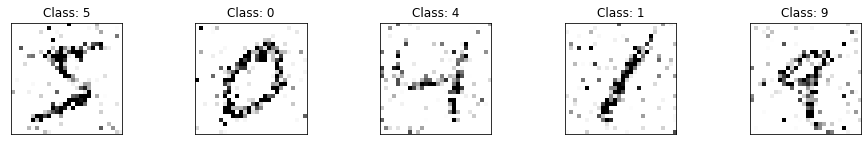

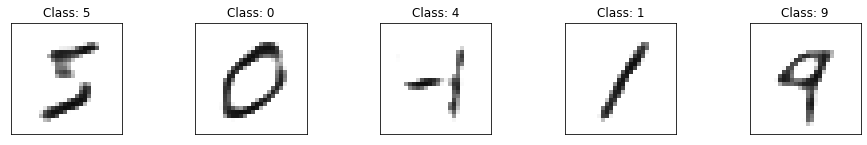

Test set


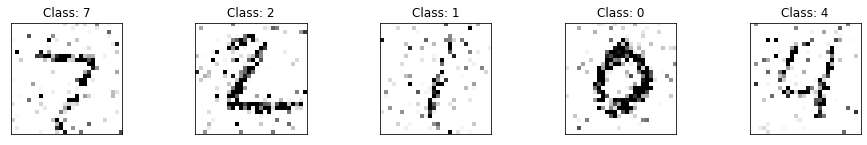

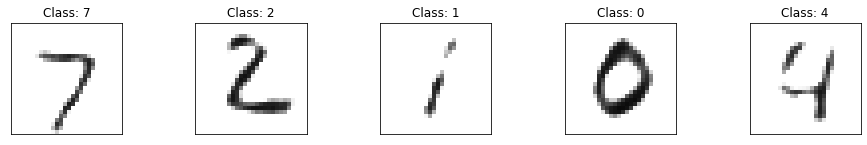

'The newly created model was able to amazingly denoise images that is one of the application of autoencoder. However, noise\nhere was really simple, practically, the noise corruption in data are usually more complex for which specialized autoencoders are used'

In [65]:
def forward_one_batch_d(model, dataset, batch_size):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)

    model.eval()

    ### BEGIN SOLUTION
    dataloader = iter(torch.utils.data.DataLoader(dataset, batch_size = batch_size))
    ims_out, ims_in, labels = next(dataloader) #unpack the data samples
    ims_out = ims_out.to(device) #Move to CUDA, if available
    with torch.no_grad(): #As we are not training, temporarily set the reguireds_grad of tensor False
      ims_est, codes = model(ims_out)
    #ims_out = 0

    ### END SOLUTION

    return ims_in, ims_out, codes, ims_est, labels


def ex_compare_reconstructions_d(model, train_set, test_set):
    print('Train set')
    ### BEGIN SOLUTION
    ims_in, ims_out, codes, ims_est, labels = forward_one_batch_d(model, train_set, batch_size = 64)
    plot_images(ims_out,ims_est, labels)
    ### END SOLUTION

    print('Test set')

    ### BEGIN SOLUTION
    ims_in, ims_out, codes, ims_est, labels = forward_one_batch_d(model, test_set, batch_size = 64)
    plot_images(ims_out, ims_est, labels)

    ### END SOLUTION


print('Plot reconstructions')
ex_compare_reconstructions_d(model_4, train_gaussnoise_set, test_gaussnoise_set)

"""The newly created model was able to amazingly denoise images that is one of the application of autoencoder. However, noise
here was really simple, practically, the noise corruption in data are usually more complex for which specialized autoencoders are used"""

## Exercise 17 : (Optional) Imputation autoencoder

Now create an AE for which the input is the image with a patch of pixels in the center set to 0.

The patch set to 0 must be a square of 10x10 pixels in the center of the image.

Train the model and plot an example of reconstructions.

In [23]:
"""Creating imputation class to add the zeroed pixel patch at center of every image"""
class AddImputation(nn.Module):
    def __init__(self, sq_width = 10):
        super().__init__()

        ### BEGIN SOLUTION
        self.patch_width = sq_width

        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        
        ims1 = (transforms.CenterCrop(
            self.patch_width)(x)).clone() #Croping the square at center with 10x10 area
        #y = x.clone ().detach ()
        #Finding the patch position in actual or orginal image
        w_min, w_max = int(len(x[0][0])/2-self.patch_width/2), int(len(x[0][0])/2+self.patch_width/2)
        x[:,w_min:w_max,w_min:w_max] = torch.zeros_like(ims1) #Zeroing the center patch of actual image now
        y = x.clone().detach()
        ### END SOLUTION
        
        return y

transform = transforms.Compose([AddImputation(10)]) #Defining imputation tranform in data

train_imputation_set = DenoisingDataset(train_set, #Get imputated train set(Retain orignial images as well)
                                        transform=transform) 
test_imputation_set = DenoisingDataset(test_set, #Get imputated test set(Retain orignial images as well)
                                       transform=transform)

input_shape = train_set[0][0].shape #Get shape of input images
train_loader = torch.utils.data.DataLoader(train_imputation_set, 
                                           batch_size=64) #Create train loader for imputed data
#Defining the new model for dealing imputation in data
model_5 = CNNAutoEncoder(input_shape, code_dim=32, base_nchan=4)

train_d(model_5, train_loader, nepochs=3) #Train with imputed data while evaluate loss on original data

ep: 0, it: 0, loss : 0.01109
ep: 0, it: 100, loss : 0.00470
ep: 0, it: 200, loss : 0.00287
ep: 0, it: 300, loss : 0.00237
ep: 0, it: 400, loss : 0.00156
ep: 0, it: 500, loss : 0.00116
ep: 0, it: 600, loss : 0.00097
ep: 0, it: 700, loss : 0.00085
ep: 0, it: 800, loss : 0.00079
ep: 0, it: 900, loss : 0.00070
ep: 1, it: 0, loss : 0.00072
ep: 1, it: 100, loss : 0.00063
ep: 1, it: 200, loss : 0.00059
ep: 1, it: 300, loss : 0.00058
ep: 1, it: 400, loss : 0.00054
ep: 1, it: 500, loss : 0.00053
ep: 1, it: 600, loss : 0.00050
ep: 1, it: 700, loss : 0.00048
ep: 1, it: 800, loss : 0.00048
ep: 1, it: 900, loss : 0.00045
ep: 2, it: 0, loss : 0.00048
ep: 2, it: 100, loss : 0.00043
ep: 2, it: 200, loss : 0.00041
ep: 2, it: 300, loss : 0.00042
ep: 2, it: 400, loss : 0.00039
ep: 2, it: 500, loss : 0.00039
ep: 2, it: 600, loss : 0.00038
ep: 2, it: 700, loss : 0.00038
ep: 2, it: 800, loss : 0.00038
ep: 2, it: 900, loss : 0.00036


Plot reconstructions
Train set


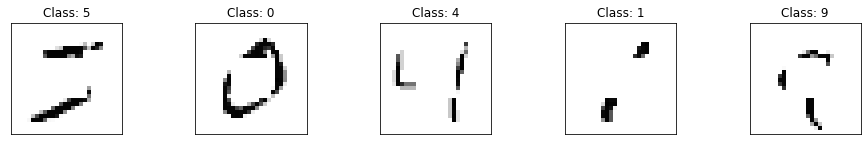

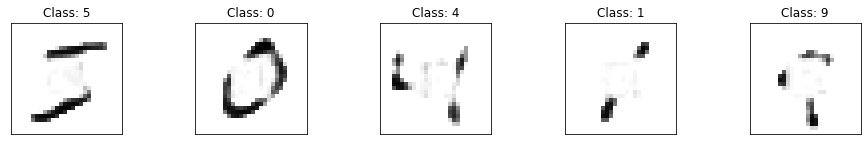

Test set


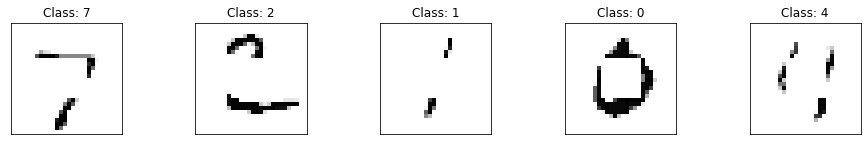

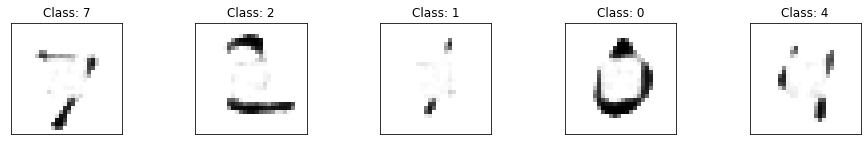

In [24]:
print('Plot reconstructions')
ex_compare_reconstructions_d(model_5, train_imputation_set, test_imputation_set)

## (Bonus) Exercise 18 : CIFAR-10

Create a new CNN AutoEncoder model and train it on [CIFAR-10](https://pytorch.org/vision/stable/datasets.html#cifar). Note that the autoencoder will require modifications to accommodate the difference in number of channels and sizes of the images in the dataset.

Run all the exercises on this new autoencoder.

In [25]:
# Defining transform for CIFAR-10 data
"""
Rather than usual transformations, I am doing one more transformation of converting 3-channels to one. The reason
is the information carried by the 3-channel and 1-channel grayscale is the same 
but in terms of weights and biases of the CNN, the CNN using 3-channel images is bigger and 
it takes more time to compute. Hoever, the earlier tasks as well as CNN has full potential (I made additional provisions) to 
even gave 3-channel results.
"""

transform_CIFAR = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.Normalize((0.5), (0.5))
])

#Brining in CIFAR-10 dataset for training
CIFARtrain_set=torchvision.datasets.CIFAR10('/content',train=True, transform = transform_CIFAR,download=True)

#Brining in CIFAR-10 dataset for testing
CIFARtest_set=torchvision.datasets.CIFAR10('/content',train=False, transform = transform_CIFAR,download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


**Answer:** CIFAR-10 datasets has input size of "3x32x32", number of classes "10" with 6000 images per class (total 60,000). The distribution between train and test data is 50000 and 10000 images respectively.

In [26]:
#from torchsummary import summary
#According to the CIFAR-10 dataset nature, the following CNN Autoencoder is design

class CNNAutoEncoderCIFAR(nn.Module):
    def __init__(self, input_shape, code_dim=32, base_nchan=6):
        super().__init__()

        input_nchan, _, _ = input_shape

        self.encoder = nn.Sequential(
            #1x32x32
            nn.Conv2d(input_nchan, base_nchan, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            #6 x 16 x 16 ***Output_size = 1 + (Input Size - Filter size + 2 * Padding) / Stride
            nn.BatchNorm2d(base_nchan), #Batch normalization used to improve training speed and stability
            nn.Tanh(),
            nn.Conv2d(base_nchan, base_nchan, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #6 x 16 x 16
            nn.BatchNorm2d(base_nchan), #Batch normalization used to improve training speed and stability
            nn.Tanh(),
            nn.Conv2d(base_nchan, base_nchan*2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            #12 x 8 x 8
            nn.BatchNorm2d(base_nchan*2), #Batch normalization used to improve training speed and stability
            nn.Tanh(),
            nn.Conv2d(base_nchan*2, base_nchan*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(base_nchan*2), #Batch normalization used to improve training speed and stability
            nn.Tanh(),
            #12 x 8 x 8
            nn.Flatten(1),
            nn.Linear(8*8*base_nchan*2, out_features=code_dim)
            ### END SOLUTION
        )

        self.decoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Linear(code_dim, out_features=8*8*base_nchan*2),
            nn.Unflatten(1, (2*base_nchan, 8, 8)),
            nn.BatchNorm2d(base_nchan*2),
            nn.Tanh(),
            nn.ConvTranspose2d(base_nchan*2, base_nchan*2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.BatchNorm2d(base_nchan*2),
            nn.Tanh(),
            nn.Conv2d(base_nchan*2, base_nchan*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(base_nchan*2),
            nn.Tanh(),
            nn.ConvTranspose2d(base_nchan*2, base_nchan, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.BatchNorm2d(base_nchan),
            nn.Tanh(),
            nn.Conv2d(base_nchan, input_nchan, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Tanh(),
            ### END SOLUTION
        )

    def forward(self, ims):
        ### BEGIN SOLUTION
        codes = self.encoder(ims) #Get codes
        decoded = self.decoder(codes) #Get estimated images
        return decoded, codes

CIFARinput_shape = CIFARtrain_set[0][0].shape #Get CIFAR images input shape

#Create data loader for CIFAR train and test images with batch size of 128
CIFARtrain_loader = torch.utils.data.DataLoader(CIFARtrain_set, batch_size=128, shuffle=True)
CIFARtest_loader = torch.utils.data.DataLoader(CIFARtest_set, batch_size=128, shuffle=False)

model_CIFAR = CNNAutoEncoderCIFAR(CIFARinput_shape, code_dim=32, base_nchan=6) #Create autoencoder for CIFAR data
print("********Training started**********")
train(model_CIFAR, CIFARtrain_loader, nepochs=3)


"""Overall the results are not good because of two reasons, we are using very simplified decoder and encoder. Another consideration is, 
even with features, it might not be enough to ensure success in certain tasks, describe in Excercise 11. Lastly, we are not training it to many epoches
as I am using colab (free) which has usage constrains. In conclusion, results could be significantly improve, if above 
considerations are given."""

********Training started**********
ep: 0, it: 0, loss : 0.00262
ep: 0, it: 100, loss : 0.00088
ep: 0, it: 200, loss : 0.00056
ep: 0, it: 300, loss : 0.00046
ep: 1, it: 0, loss : 0.00042
ep: 1, it: 100, loss : 0.00039
ep: 1, it: 200, loss : 0.00037
ep: 1, it: 300, loss : 0.00036
ep: 2, it: 0, loss : 0.00035
ep: 2, it: 100, loss : 0.00035
ep: 2, it: 200, loss : 0.00034
ep: 2, it: 300, loss : 0.00034


Plot reconstructions
Train set


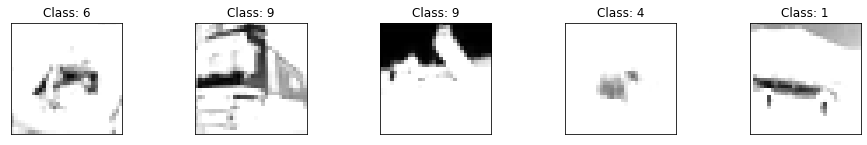

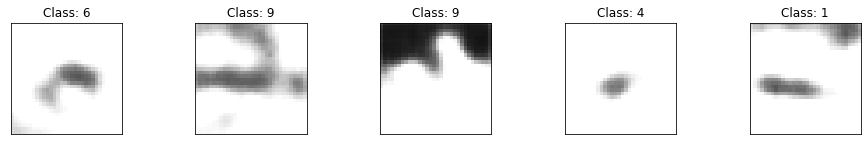

Test set


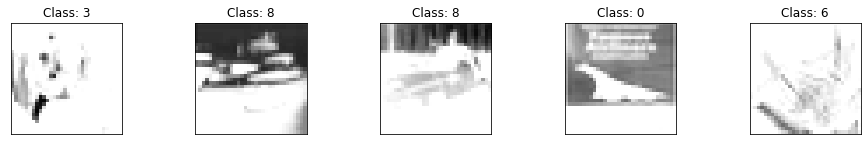

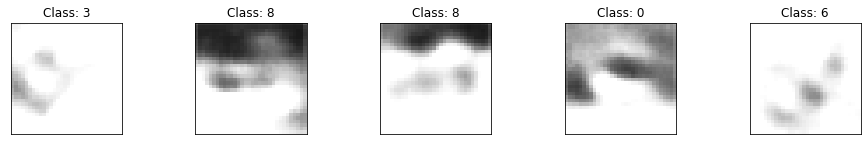

Plot the 1st and 2nd dimensions of codes


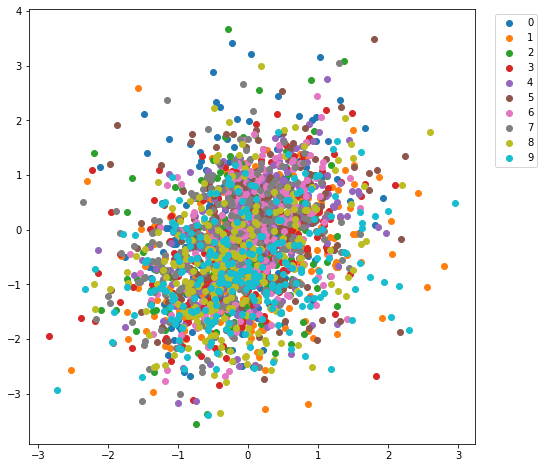

Plot the PCA of codes


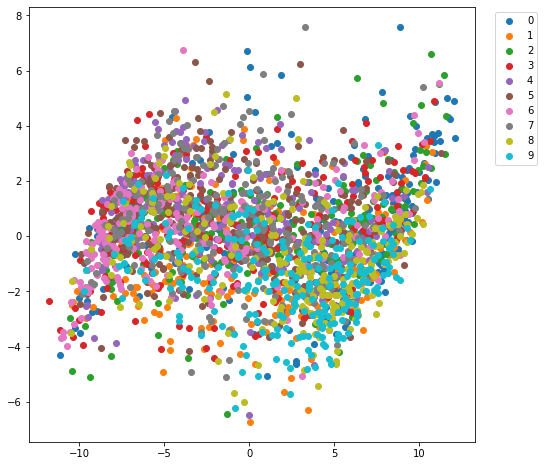

Plot the TSNE of codes


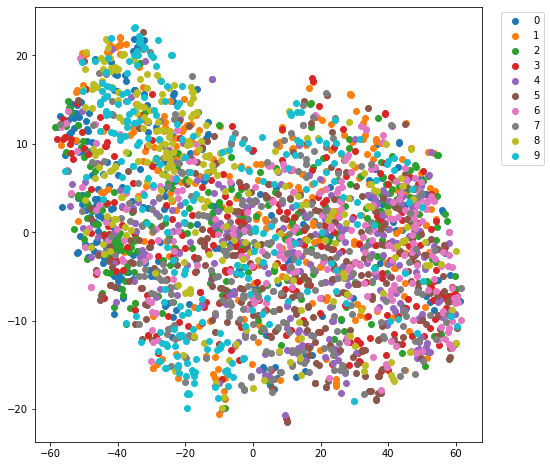

Classify using codes
Pixel space accuracy: 19.16%
Latent space accuracy: 20.02%
Generate random images


<Figure size 1152x324 with 0 Axes>

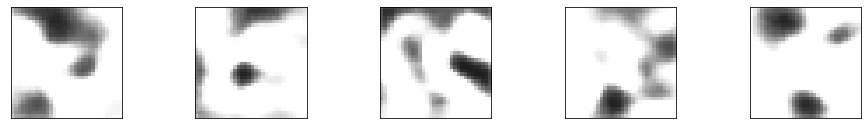

Generate particular digits


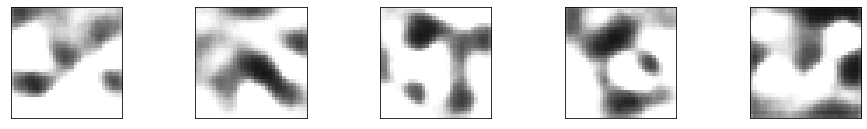

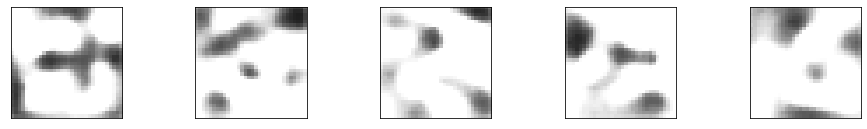

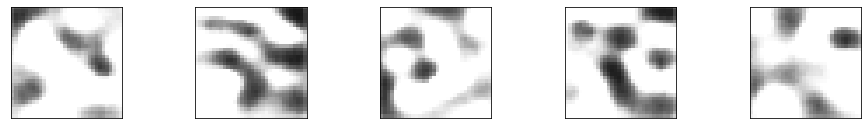

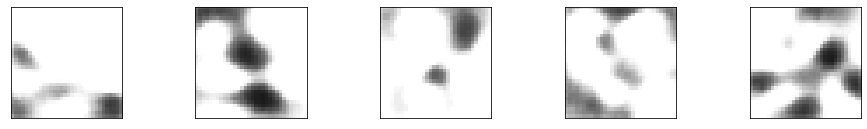

Interpolate between images
Interpolated Images from pixel space


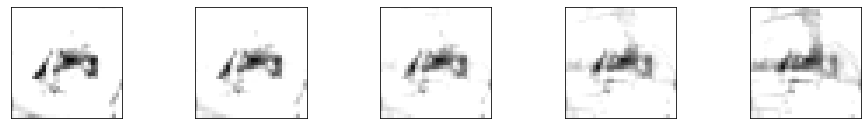

Interpolated images from codes


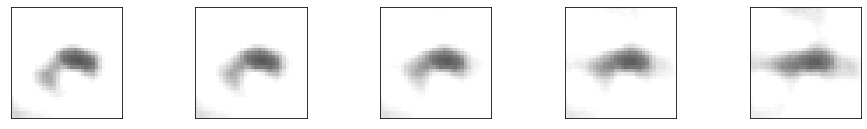

In [27]:
print('Plot reconstructions')
ex_compare_reconstructions(model_CIFAR, CIFARtrain_set, CIFARtest_set)

print('Plot the 1st and 2nd dimensions of codes')
ex_plot_codes(model_CIFAR, CIFARtrain_set)

print('Plot the PCA of codes')
ex_plot_codes_pca(model_CIFAR, CIFARtrain_set)

print('Plot the TSNE of codes')
ex_plot_codes_tsne(model_CIFAR, CIFARtrain_set)

print('Classify using codes')
ex_compare_classifiers(model_CIFAR, CIFARtrain_set, CIFARtest_set)

print('Generate random images')
ex_generate_images(model_CIFAR, CIFARtrain_set)

print('Generate particular classes')
ex_generate_digit_images(model_CIFAR, CIFARtrain_set, digit=0)
ex_generate_digit_images(model_CIFAR, CIFARtrain_set, digit=1)
ex_generate_digit_images(model_CIFAR, CIFARtrain_set, digit=2)
ex_generate_digit_images(model_CIFAR, CIFARtrain_set, digit=3)

print('Interpolate between images')
ex_compare_interpolation(model_CIFAR, CIFARtrain_set)


ep: 0, it: 0, loss : 0.00261
ep: 0, it: 100, loss : 0.00107
ep: 0, it: 200, loss : 0.00070
ep: 0, it: 300, loss : 0.00062
ep: 1, it: 0, loss : 0.00057
ep: 1, it: 100, loss : 0.00054
ep: 1, it: 200, loss : 0.00052
ep: 1, it: 300, loss : 0.00050
ep: 2, it: 0, loss : 0.00049
ep: 2, it: 100, loss : 0.00048
ep: 2, it: 200, loss : 0.00048
ep: 2, it: 300, loss : 0.00048
Plot reconstructions
ep: 0, it: 0, loss : 0.00466
ep: 0, it: 100, loss : 0.00196
ep: 0, it: 200, loss : 0.00119
ep: 0, it: 300, loss : 0.00103
ep: 0, it: 400, loss : 0.00090
ep: 0, it: 500, loss : 0.00082
ep: 0, it: 600, loss : 0.00074
ep: 0, it: 700, loss : 0.00069
ep: 1, it: 0, loss : 0.00068
ep: 1, it: 100, loss : 0.00066
ep: 1, it: 200, loss : 0.00064
ep: 1, it: 300, loss : 0.00064
ep: 1, it: 400, loss : 0.00063
ep: 1, it: 500, loss : 0.00063
ep: 1, it: 600, loss : 0.00062
ep: 1, it: 700, loss : 0.00060
ep: 2, it: 0, loss : 0.00061
ep: 2, it: 100, loss : 0.00060
ep: 2, it: 200, loss : 0.00059
ep: 2, it: 300, loss : 0.00060

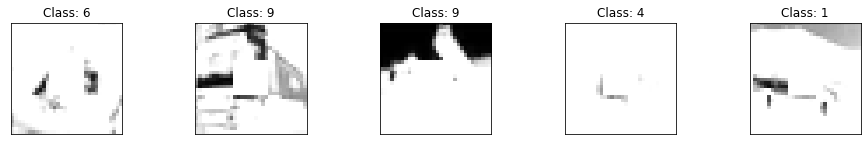

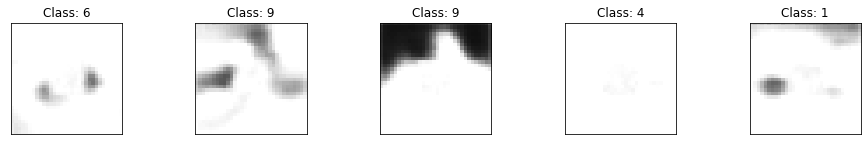

Test set


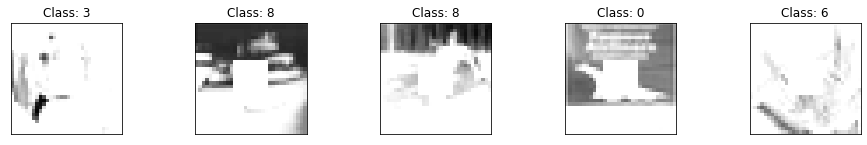

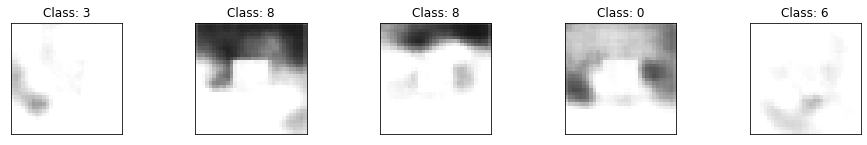

In [28]:
transform1 = transforms.Compose([AddGaussianNoise(0, noise_factor), Clip(0, 1)])

CIFARtrain_gaussnoise_set = DenoisingDataset(CIFARtrain_set, 
                                        transform=transform1)
CIFARtest_gaussnoise_set = DenoisingDataset(CIFARtest_set, 
                                       transform=transform1)

CIFARtrain_loader = torch.utils.data.DataLoader(CIFARtrain_gaussnoise_set, batch_size=128)

model_CIFAR2 = CNNAutoEncoderCIFAR(CIFARinput_shape, code_dim=32, base_nchan=4)

train_d(model_CIFAR2, CIFARtrain_loader, nepochs=3)
print('Plot reconstructions')
#ex_compare_reconstructions_d(model_CIFAR2, CIFARtrain_gaussnoise_set, CIFARtest_gaussnoise_set)

#Imputation excercise over CIFAR10
transform2 = transforms.Compose([AddImputation(10)])

CIFARtrain_imputation_set = DenoisingDataset(CIFARtrain_set, 
                                        transform=transform2)
CIFARtest_imputation_set = DenoisingDataset(CIFARtest_set, 
                                       transform=transform2)

CIFARtrain_loader = torch.utils.data.DataLoader(CIFARtrain_imputation_set, batch_size=64)
model_CIFAR3 = CNNAutoEncoderCIFAR(CIFARinput_shape, code_dim=32, base_nchan=4)

train_d(model_CIFAR3, CIFARtrain_loader, nepochs=3)
print('Plot reconstructions')
ex_compare_reconstructions_d(model_CIFAR3, CIFARtrain_imputation_set, CIFARtest_imputation_set)

## (Bonus) Exercise 19 : MobileNet v2 as encoder for CIFAR-10

You may now modify the autoencoder so that it uses a MobileNet v2 feature extractor as encoder.

You may try fine-tuning or using a fixed version of the MobileNet v2 model pretrained on ImageNet.

As usual run all the exercises on this new autoencoder.

In [29]:
import torchvision.models as models

transform = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Brining CIFAR10 data that is not grayscale for given problem
train2_cifar10 = torchvision.datasets.CIFAR10(root="data", train=True, download=True,
    transform=transform)

test2_cifar10 = torchvision.datasets.CIFAR10(root="data",train=False,
    download=True, transform=transform)

class MobileCNNAutoEncoder(CNNAutoEncoderCIFAR): #Inherenting CIFAR model from earlier class to use earlier decoder
    def __init__(self, input_shape, code_dim=32, base_nchan=6):
        super().__init__(input_shape, code_dim=32, base_nchan=6) #Additional arguments required for argument-based class inheretance
        input_nchan, _, _ = input_shape
        # Loading the pretrained model in the nn.Sequential
        #Adding the relu at output and then adding one additional trainable layer
        #to learn features in our case
        MN_v2 = models.mobilenet_v2(pretrained=True) 
        #The general output of mobilenetv2 is classification (1000 classes) but we will utilize 
        #here only feature extraction (second last layer before classification) using ".features"
        self.encoder = nn.Sequential(MN_v2.features, nn.Flatten(), #and make it
                                     nn.ReLU(), nn.Linear(MN_v2.last_channel, code_dim))
        # the output of the encoder is 32 (Made similar to earlier networks as well as make last layer trainable 
        #for additional provision of transfer learning to improve results)

    def forward(self, ims):
        ### BEGIN SOLUTION
        codes = self.encoder(ims)
        # Compute the estimated images using the decoder
        ims_est = self.decoder(codes)  #Decoder from inhereted class
    
        ### END SOLUTION
        return ims_est, codes

CIFARinput_shape = train2_cifar10[0][0].shape #3, 32, 32

CIFARtrain_loader = torch.utils.data.DataLoader(train2_cifar10, batch_size=64)
model_CIFAR4 = MobileCNNAutoEncoder(CIFARinput_shape, code_dim=32, base_nchan=6)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [30]:
train(model_CIFAR4, CIFARtrain_loader, nepochs=3)

ep: 0, it: 0, loss : 0.00537
ep: 0, it: 100, loss : 0.00294
ep: 0, it: 200, loss : 0.00215
ep: 0, it: 300, loss : 0.00203
ep: 0, it: 400, loss : 0.00190
ep: 0, it: 500, loss : 0.00187
ep: 0, it: 600, loss : 0.00178
ep: 0, it: 700, loss : 0.00172
ep: 1, it: 0, loss : 0.00172
ep: 1, it: 100, loss : 0.00165
ep: 1, it: 200, loss : 0.00160
ep: 1, it: 300, loss : 0.00161
ep: 1, it: 400, loss : 0.00155
ep: 1, it: 500, loss : 0.00154
ep: 1, it: 600, loss : 0.00151
ep: 1, it: 700, loss : 0.00149
ep: 2, it: 0, loss : 0.00150
ep: 2, it: 100, loss : 0.00150
ep: 2, it: 200, loss : 0.00148
ep: 2, it: 300, loss : 0.00150
ep: 2, it: 400, loss : 0.00150
ep: 2, it: 500, loss : 0.00150
ep: 2, it: 600, loss : 0.00148
ep: 2, it: 700, loss : 0.00146


Below is the excercise run of newly created CNNAE on allthe initial tasks except denoising tasks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Plot reconstructions
Train set


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


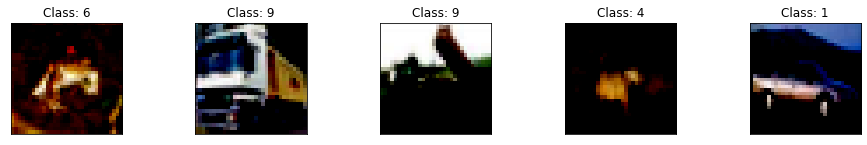

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


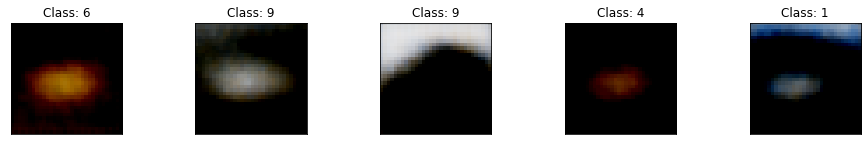

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test set


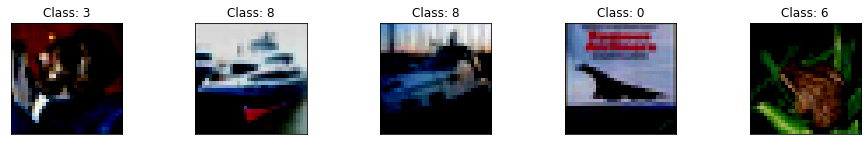

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


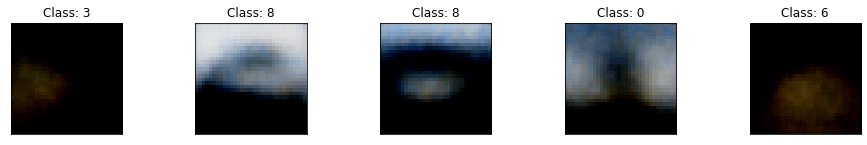

Plot the 1st and 2nd dimensions of codes


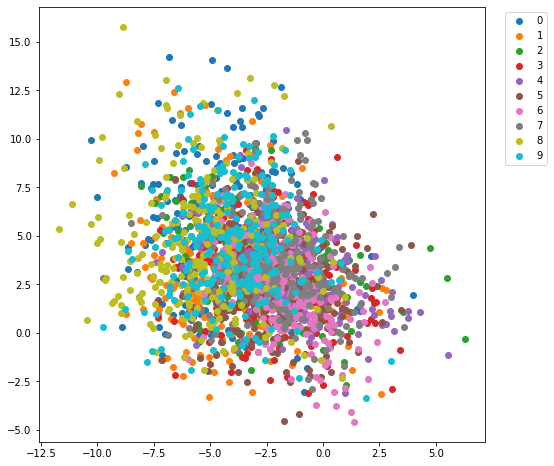

Plot the PCA of codes


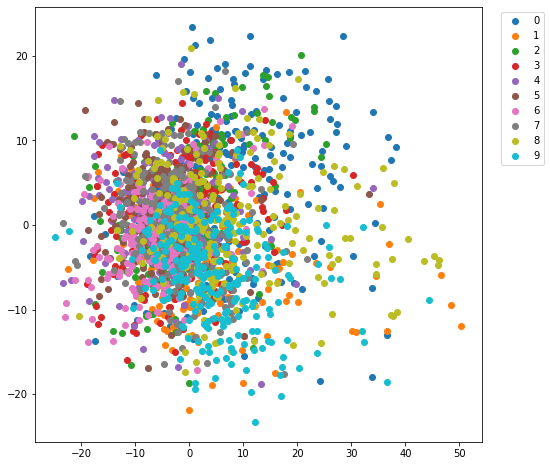

Plot the TSNE of codes


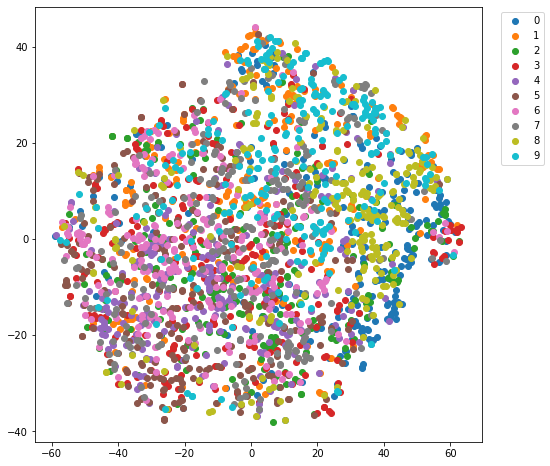

Classify using codes
Pixel space accuracy: 22.38%
Latent space accuracy: 25.10%
Generate random images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1152x324 with 0 Axes>

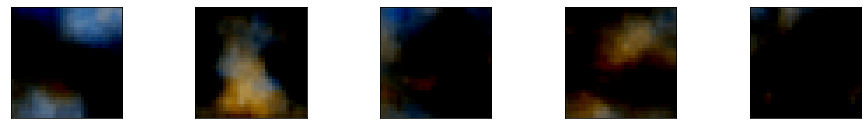

Generate particular classes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


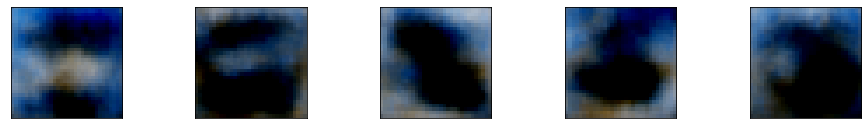

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


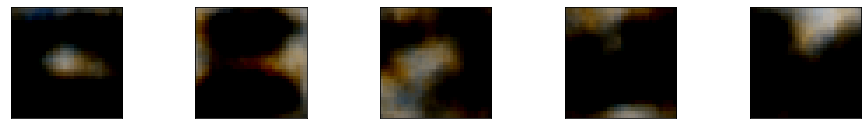

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


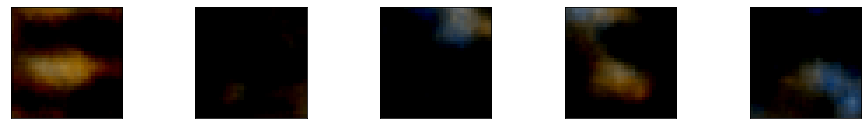

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


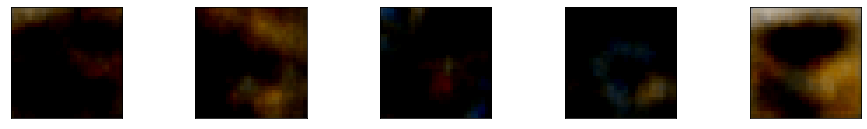

Interpolate between images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Interpolated Images from pixel space


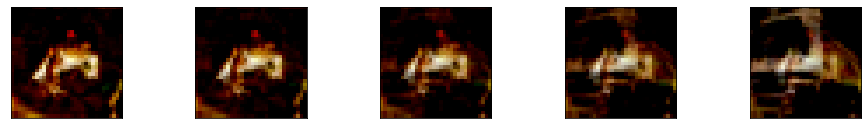

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Interpolated images from codes


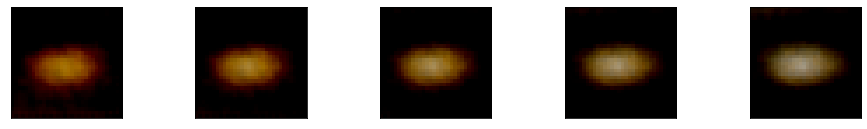

In [66]:
print('Plot reconstructions')
ex_compare_reconstructions(model_CIFAR4, train2_cifar10, test2_cifar10)

print('Plot the 1st and 2nd dimensions of codes')
ex_plot_codes(model_CIFAR4, train2_cifar10)

print('Plot the PCA of codes')
ex_plot_codes_pca(model_CIFAR4, train2_cifar10)

print('Plot the TSNE of codes')
ex_plot_codes_tsne(model_CIFAR4, train2_cifar10)

print('Classify using codes')
ex_compare_classifiers(model_CIFAR4, train2_cifar10, test2_cifar10)

print('Generate random images')
ex_generate_images(model_CIFAR4, train2_cifar10)

print('Generate particular classes')
ex_generate_digit_images(model_CIFAR4, train2_cifar10, digit=0)
ex_generate_digit_images(model_CIFAR4, train2_cifar10, digit=1)
ex_generate_digit_images(model_CIFAR4, train2_cifar10, digit=2)
ex_generate_digit_images(model_CIFAR4, train2_cifar10, digit=3)

print('Interpolate between images')
ex_compare_interpolation(model_CIFAR4, train2_cifar10)

"""Overall the results are not good because of three reasons, we are using very simplified decoder. Secondly, the mobile net is not
fine tuned to the given task (except the additional last layer - transfer learning) and another consideration is even with features,
it is not enough to ensure success in certain tasks, describe in EXcercise 11. Lastly, we are not training it to many epoches
as I am using colab (free) which has usage constrains. In conclusion, results could be significantly improve, if above 
considerations are given."""

## (Bonus) Exercise 20 : Double-resolution autoencoder

We have seen so far AEs that don't change size between inputs and outputs. But we may well have some that don't (e.g. increase the image resolution). We will here create a model that upsamples by 2 an input image (doubles the height and width of the input image).

You may use the dataset of choice: MNIST or CIFAR-10.

Adapt the `CNNAutoEncoder` to create an AE model that doubles the resolution of input images. Make it take as input images of size 14x14 and outputs images of size 28x28.

Instantiate a `DenoisingDataset` that will return input images that are half-sized versions of the original ones.

Train the model and plot some examples.

In [32]:
"""CNN AutoEncoder for upsampling an MNIST dataset (images of 14x14 to 28x28)"""

class UpSamplerCNNAutoEncoder(CNNAutoEncoder): #Inhereting CNNAutoencoder Class here (using the same encoder)                                                           
    def __init__(self, input_shape, code_dim=32, base_nchan=6): #with our new decoder
        super().__init__(input_shape, code_dim=32, base_nchan=6) #Necessary changes for inhereting for earlier CNN class
        input_nchan, _, _  = input_shape

        self.UpSamplingDecoder = nn.Sequential(
            ### BEGIN SOLUTION
            nn.Linear(code_dim, out_features=4*4*base_nchan*2), #12x4x4 (if base_nchan = 6)
            nn.Unflatten(1, (base_nchan*2, 4, 4)),
            #12x4x4 %%I could have used out_feature to make it to 7x7 without sample, but this way the model 
            #has more parameters to train but similar score (more computations are not good if getting similar results)
            nn.ConvTranspose2d(base_nchan*2, base_nchan*2, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            #12x7x7 #Above I changed the above layer kernal size from earlier (3x3) to now (2x2)
            nn.Upsample(scale_factor=2, mode='nearest'), #To double the x and y
            nn.Tanh(),
            #12x14x14
            nn.Conv2d(base_nchan*2, base_nchan*2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #output size = 12x14x14
            nn.Tanh(),
            nn.ConvTranspose2d(base_nchan*2, base_nchan, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.Tanh(), #Output size of above layer = #6x28x28
            nn.Conv2d(base_nchan, input_nchan, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Tanh() ##Output size of above layer = #6x28x28
            ### END SOLUTION
        )

    def forward(self, ims):
        ### BEGIN SOLUTION
        codes = self.encoder(ims)
        decoded = self.UpSamplingDecoder(codes)
        return decoded, codes

input_shape = train_set[0][0].shape

In [33]:

transform = transforms.Resize((14,14))

train_halfresolution_set = DenoisingDataset(train_set, 
                                        transform=transform)
test_halfresolution_set = DenoisingDataset(test_set, 
                                       transform=transform)

input_shape_halfresolution = train_halfresolution_set[0][0].shape


HalfResolution_train_loader = torch.utils.data.DataLoader(train_halfresolution_set, batch_size=64)

model_6 = UpSamplerCNNAutoEncoder(input_shape_halfresolution, code_dim = 32, base_nchan = 6)

train_d(model_6, HalfResolution_train_loader, nepochs=3)

ep: 0, it: 0, loss : 0.01245
ep: 0, it: 100, loss : 0.00596
ep: 0, it: 200, loss : 0.00432
ep: 0, it: 300, loss : 0.00422
ep: 0, it: 400, loss : 0.00379
ep: 0, it: 500, loss : 0.00274
ep: 0, it: 600, loss : 0.00210
ep: 0, it: 700, loss : 0.00172
ep: 0, it: 800, loss : 0.00155
ep: 0, it: 900, loss : 0.00137
ep: 1, it: 0, loss : 0.00138
ep: 1, it: 100, loss : 0.00123
ep: 1, it: 200, loss : 0.00115
ep: 1, it: 300, loss : 0.00113
ep: 1, it: 400, loss : 0.00107
ep: 1, it: 500, loss : 0.00105
ep: 1, it: 600, loss : 0.00101
ep: 1, it: 700, loss : 0.00098
ep: 1, it: 800, loss : 0.00095
ep: 1, it: 900, loss : 0.00089
ep: 2, it: 0, loss : 0.00093
ep: 2, it: 100, loss : 0.00085
ep: 2, it: 200, loss : 0.00082
ep: 2, it: 300, loss : 0.00082
ep: 2, it: 400, loss : 0.00078
ep: 2, it: 500, loss : 0.00078
ep: 2, it: 600, loss : 0.00075
ep: 2, it: 700, loss : 0.00074
ep: 2, it: 800, loss : 0.00073
ep: 2, it: 900, loss : 0.00069


Train set


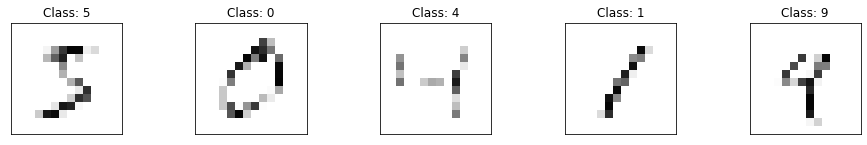

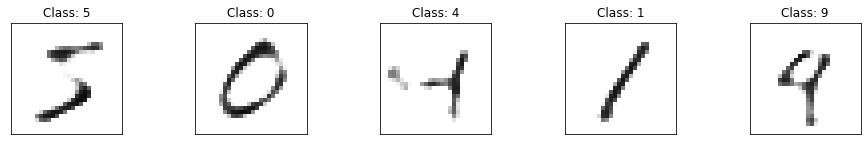

Test set


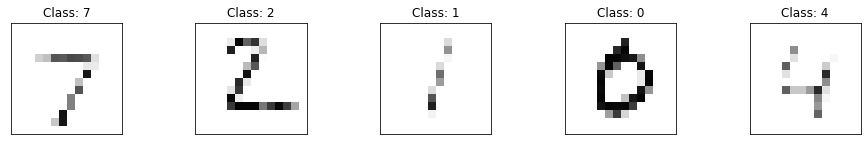

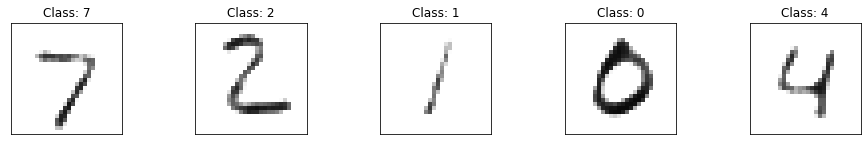

'We clearly see that the autoencoder really improves the resolution of images and those images are much clear now (estimated images).\nI believe, this is one of the application'

In [34]:
ex_compare_reconstructions_d(model_6, train_halfresolution_set, test_halfresolution_set)

"""We clearly see that the autoencoder really improves the resolution of images and those images are much clear now (estimated images).
I believe, this is one of the application"""

## (Have fun) Exercise 21 : Train an AutoEncoder on any transformation of your choice

This time train an AE on whatever image transformation you can come up with. Let free your creativity and don't be afraid to test the limits of such auto-encoding approach.

The more original the transformation the better :-)